# Código de Implementación de Modelos y Cálculo de Masas Invariantes en la Base de Datos 'Run2012B_DoubleElectron'

In [1]:
import numpy as np
import h5py
import uproot

treename = 'Events;1'
filename = {}
upfile = {}
params = {}

filename['2012B'] = 'Run2012B_DoubleElectron.root'

upfile['2012B'] = uproot.open(filename['2012B']) #devuelve un AwkwardArray

params['2012B'] = upfile['2012B'][treename].arrays() # returns a dictionary of arrays


In [2]:
len(params['2012B'])

21474287

In [3]:
import numpy as np
import awkward as ak

def filter_electrons(array):
    # Filtro: Al menos cuatro electrones
    array = array[array['nElectron'] == 4]

    # Filtro: Buena aislación (pfRelIso03_all < 0.40)
    array = array[ak.all(np.absolute(array['Electron_pfRelIso03_all']) < 0.40, axis=1)]

    # Filtro: Buena cinemática para electrones (pt > 7 y |eta| < 2.5)
    array = array[ak.all(array['Electron_pt'] > 7, axis=1)]
    array = array[ak.all(np.absolute(array['Electron_eta']) < 2.5, axis=1)]

    # Definición de nueva columna: Electron_ip3d
    array['Electron_ip3d'] = [[(a**2 + b**2)**0.5 for a, b in zip(x, y)] for x, y in zip(array['Electron_dxy'], array['Electron_dz'])]

    # Definición de nueva columna: Electron_sip3d
    # Itera simultáneamente sobre las tres listas y calcula el resultado componente a componente
    Electron_sip3d_list = []
    for ip3d, dxy_err, dz_err in zip(array['Electron_ip3d'], array['Electron_dxyErr'], array['Electron_dzErr']):
        sip3d_components = [ip3d_val / np.sqrt(dxy_err_val**2 + dz_err_val**2) for ip3d_val, dxy_err_val, dz_err_val in zip(ip3d, dxy_err, dz_err)]
        Electron_sip3d_list.append(sip3d_components)
    array['Electron_sip3d'] = Electron_sip3d_list

    # Filtro: Seguimiento cercano al vértice primario con pequeña incertidumbre
    array = array[ak.all(array['Electron_sip3d'] < 4, axis=1)]
    array = array[ak.all(np.absolute(array['Electron_dxy']) < 0.5, axis=1)]
    array = array[ak.all(np.absolute(array['Electron_dz']) < 1.0, axis=1)]

    # Filtro: Cuatro electrones. Dos positivos y dos negativos
    array = array[(ak.count(array['Electron_charge'], axis=1) == 4) &
                  (ak.sum(array['Electron_charge'] == 1, axis=1) == 2) &
                  (ak.sum(array['Electron_charge'] == -1, axis=1) == 2)]

    return array

In [4]:
array_four_e = filter_electrons(params['2012B'])

In [5]:
len(array_four_e)

33

In [6]:
def pt_cuts(mu_pt, el_pt):
    results = []
    for mu_pt_entry, el_pt_entry in zip(mu_pt, el_pt):
        if len(mu_pt_entry) >= 2 and len(el_pt_entry) >= 2:  # Verificar que haya al menos dos elementos
            mu_pt_sorted = np.sort(mu_pt_entry)[::-1]  # Reverse sort
            el_pt_sorted = np.sort(el_pt_entry)[::-1]  # Reverse sort
            if mu_pt_sorted[0] > 20 and mu_pt_sorted[1] > 10 and el_pt_sorted[0] > 20 and el_pt_sorted[1] > 10:
                results.append(True)
            else:
                results.append(False)
        else:
            results.append(False)  # Si el arreglo está vacío o tiene menos de dos elementos, no se cumplen los cortes
    return results

def dr_cuts(mu_eta, mu_phi, el_eta, el_phi):
    results = []
    for mu_eta_entry, mu_phi_entry, el_eta_entry, el_phi_entry in zip(mu_eta, mu_phi, el_eta, el_phi):
        # Verificar que hay al menos dos elementos en cada arreglo
        if len(mu_eta_entry) < 2 or len(mu_phi_entry) < 2 or len(el_eta_entry) < 2 or len(el_phi_entry) < 2:
            results.append(False)   
        else:
            # Calcular las distancias delta R para cada par de elementos
            mu_dr = np.sqrt((mu_eta_entry[0] - mu_eta_entry[1])**2 + (mu_phi_entry[0] - mu_phi_entry[1])**2)
            el_dr = np.sqrt((el_eta_entry[0] - el_eta_entry[1])**2 + (el_phi_entry[0] - el_phi_entry[1])**2)
            
            # Aplicar la condición de corte a cada par por separado
            mu_pass = mu_dr <= 0.02
            el_pass = el_dr <= 0.02
            
            # Verificar si al menos uno de los pares satisface la condición
            if mu_pass or el_pass:
                results.append(False)
            else:
                results.append(True)
    return results


def filter_array(array):
    array_filtered = array[(array['nElectron'] == 2) & (array['nMuon'] == 2)]
    array_filtered = array_filtered[(ak.all(np.absolute(array_filtered['Electron_eta']) < 2.5, axis=1) & ak.all(np.absolute(array_filtered['Muon_eta']) < 2.4, axis=1))]    
    
    array_filtered = array_filtered[pt_cuts(array_filtered['Muon_pt'], array_filtered['Electron_pt'])]
    array_filtered = array_filtered[dr_cuts(array_filtered['Muon_eta'], array_filtered['Muon_phi'], array_filtered['Electron_eta'], array_filtered['Electron_phi'])]
    
    array_filtered = array_filtered[ak.all(array_filtered['Electron_pfRelIso03_all'] < 0.40, axis=1)]
    array_filtered = array_filtered[ak.all(array_filtered['Muon_pfRelIso04_all'] < 0.40, axis=1)]

    # Definición de nueva columna: Electron_ip3d
    array_filtered['Electron_ip3d'] = [[(a**2 + b**2)**0.5 for a, b in zip(x, y)] for x, y in zip(array_filtered['Electron_dxy'], array_filtered['Electron_dz'])]
    Electron_sip3d_list = []
    for ip3d, dxy_err, dz_err in zip(array_filtered['Electron_ip3d'], array_filtered['Electron_dxyErr'], array_filtered['Electron_dzErr']):
        sip3d_components = [ip3d_val / np.sqrt(dxy_err_val**2 + dz_err_val**2) for ip3d_val, dxy_err_val, dz_err_val in zip(ip3d, dxy_err, dz_err)]
        Electron_sip3d_list.append(sip3d_components)
    array_filtered['Electron_sip3d'] = Electron_sip3d_list
    
    # Definición de nueva columna: Muon_ip3d
    array_filtered['Muon_ip3d'] = [[(a**2 + b**2)**0.5 for a, b in zip(x, y)] for x, y in zip(array_filtered['Muon_dxy'], array_filtered['Muon_dz'])]
    Muon_sip3d_list = []
    for ip3d, dxy_err, dz_err in zip(array_filtered['Muon_ip3d'], array_filtered['Muon_dxyErr'], array_filtered['Muon_dzErr']):
        sip3d_components = [ip3d_val / np.sqrt(dxy_err_val**2 + dz_err_val**2) for ip3d_val, dxy_err_val, dz_err_val in zip(ip3d, dxy_err, dz_err)]
        Muon_sip3d_list.append(sip3d_components)
    array_filtered['Muon_sip3d'] = Muon_sip3d_list
    
    array_filtered = array_filtered[ak.all(array_filtered['Electron_sip3d'] < 4, axis=1)]
    array_filtered = array_filtered[ak.all(array_filtered['Muon_sip3d'] < 4, axis=1)]
    array_filtered = array_filtered[ak.all(np.absolute(array_filtered['Electron_dxy']) < 0.5, axis=1)]
    array_filtered = array_filtered[ak.all(np.absolute(array_filtered['Electron_dz']) < 1.0, axis=1)]
    array_filtered = array_filtered[ak.all(np.absolute(array_filtered['Muon_dxy']) < 0.5, axis=1)]
    array_filtered = array_filtered[ak.all(np.absolute(array_filtered['Muon_dz']) < 1.0, axis=1)]

    condicion = []
    for val_e, val_m in zip(array_filtered['Electron_charge'], array_filtered['Muon_charge']):
        charge_e = 0
        charge_m = 0
        for a in val_e:
            charge_e += a
        for b in val_m:
            charge_m += b
        if charge_e == 0 and charge_m == 0:
            condicion.append(True)
        else:
            condicion.append(False)   
    array_filtered = array_filtered[condicion]
    return array_filtered


In [7]:
array_twotwo = filter_array(params['2012B'])

In [8]:
len(array_twotwo)

41

In [9]:
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

#Reconstrucción de los dos candidatos a bosón Z a partir de los 4 leptones del mismo tipo
def reconstruct_samekind(array):    
    z_mass = 91.2
    idx = np.zeros((2, 2), dtype=int)
    #Genera todas los pares de combinaciones posibles con el número de electrones que hay que serán 4
    pairs = list(combinations(range(len(array['Electron_pt'][0])), 2)) 
    z_idx = [] #lista donde guardar los índices de cada fila para crear una nueva columna en el dataframe
    for pt, eta, phi, mass, charge in zip(array['Electron_pt'],array['Electron_eta'],array['Electron_phi'],array['Electron_mass'],array['Electron_charge']): 
        # Encuentra el primer par de leptones con la masa invariante más cercana a la masa del bosón Z
        best_mass = -1
        for i1, i2 in pairs:
            if charge[i1] != charge[i2]:
               # Calcular componentes de energía y momento lineal para cada lepton
                energy1 = np.sqrt((pt[i1]*np.cosh(eta[i1]))**2 + mass[i1]**2)
                energy2 = np.sqrt((pt[i2]*np.cosh(eta[i2]))**2 + mass[i2]**2)
                px1 = pt[i1] * np.cos(phi[i1])
                py1 = pt[i1] * np.sin(phi[i1])
                pz1 = pt[i1] * np.sinh(eta[i1])
                px2 = pt[i2] * np.cos(phi[i2])
                py2 = pt[i2] * np.sin(phi[i2])
                pz2 = pt[i2] * np.sinh(eta[i2])

                # Calcular la masa invariante
                this_mass = np.sqrt((energy1 + energy2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
                if np.abs(z_mass - this_mass) < np.abs(z_mass - best_mass):
                    best_mass = this_mass
                    best_i1, best_i2 = i1, i2
        
        idx[0] = [best_i1, best_i2]
        # Reconstrucción del segundo bosón Z a partir del par de leptones restantes
        remaining_indices = [i for i in range(4) if i != best_i1 and i != best_i2]
        idx[1] = remaining_indices
        z_idx.append(idx.copy())
    return z_idx

In [10]:
z_idx = reconstruct_samekind(array_four_e)

In [11]:
def calcular_energia_momento(pt, eta, phi, mass):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    energy = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
    return energy, px, py, pz

# Función para crear los cuadrivectores a partir de las componentes de energía y momento
def crear_cuadrivector(energy, px, py, pz):
    return np.array([energy, px, py, pz])

def calcular_masa_invariante(cuadrivector):
    energy = cuadrivector[0]
    momentum_modulus_squared = np.sum(cuadrivector[1:]**2)
    invariant_mass_squared = energy**2 - momentum_modulus_squared
    invariant_mass = np.sqrt(invariant_mass_squared)
    return invariant_mass

# Función principal para calcular los cuadrivectores de las partículas
def z_fourvectors_samekind(z_idx, array):
    lista_z_fourvecs = []
    z_mass = 91.2
    for fila in range(len(z_idx)):
        pt = array['Electron_pt'][fila]
        eta = array['Electron_eta'][fila]
        phi = array['Electron_phi'][fila]
        mass = array['Electron_mass'][fila]
        z_fourvecs = np.zeros((2, 4))  # Crear arreglo para almacenar cuadrivectores
        for i in range(2):
            i1 = z_idx[fila][i][0]
            i2 = z_idx[fila][i][1]
            energy1, px1, py1, pz1 = calcular_energia_momento(pt[i1], eta[i1], phi[i1], mass[i1])
            energy2, px2, py2, pz2 = calcular_energia_momento(pt[i2], eta[i2], phi[i2], mass[i2])
            cuadrivector = crear_cuadrivector(energy1 + energy2, px1 + px2, py1 + py2, pz1 + pz2)
            z_fourvecs[i] = cuadrivector

        # Ordenar cuadrivectores según proximidad a la masa del bosón Z
        if abs(calcular_masa_invariante(z_fourvecs[0]) - z_mass) < abs(calcular_masa_invariante(z_fourvecs[1]) - z_mass):
            lista_z_fourvecs.append(z_fourvecs)
        else:
            z_fourvecs = z_fourvecs[::-1]
            lista_z_fourvecs.append(z_fourvecs)

    return lista_z_fourvecs

In [12]:
lista_z_fourvecs = z_fourvectors_samekind(z_idx, array_four_e)

In [13]:
# Función para calcular la energía y el momento de una partícula a partir de sus componentes
def calcular_energia_momento(pt, eta, phi, mass):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    energy = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
    return energy, px, py, pz

# Función para crear los cuadrivectores a partir de las componentes de energía y momento
def crear_cuadrivector(energy, px, py, pz):
    return np.array([energy, px, py, pz])

def calcular_masa_invariante(cuadrivector):
    energy = cuadrivector[0]
    momentum_modulus_squared = np.sum(cuadrivector[1:]**2)
    invariant_mass_squared = energy**2 - momentum_modulus_squared
    invariant_mass = np.sqrt(invariant_mass_squared)
    return invariant_mass

def z_fourvectors_2el2mu(array):
    lista_z_fourvecs = [] #lista para meter cada cuadruvetcor de cada fila. Habrá dos por fila por cada par de electrones
    z_mass = 91.2
    for fila in range(0,len(array)):
        el_pt = array['Electron_pt'][fila]   
        el_eta = array['Electron_eta'][fila]   
        el_phi = array['Electron_phi'][fila]   
        el_mass = array['Electron_mass'][fila]   
        mu_pt = array['Muon_pt'][fila]   
        mu_eta = array['Muon_eta'][fila]   
        mu_phi = array['Muon_phi'][fila]   
        mu_mass = array['Muon_mass'][fila]  
        z_fourvecs = np.zeros((2,), dtype=object)
        i1 = 0 #índice primer electrón
        i2 = 1 #índice segundo electrón
        i3 = 0 #índice primer muón
        i4 = 1 #índice segundo muón
        energy_e1, px_e1, py_e1, pz_e1 = calcular_energia_momento(el_pt[i1], el_eta[i1], el_phi[i1], el_mass[i1]) 
        energy_e2, px_e2, py_e2, pz_e2 = calcular_energia_momento(el_pt[i2], el_eta[i2], el_phi[i2], el_mass[i2])
        energy_m1, px_m1, py_m1, pz_m1 = calcular_energia_momento(mu_pt[i3], mu_eta[i3], mu_phi[i3], mu_mass[i3])
        energy_m2, px_m2, py_m2, pz_m2 = calcular_energia_momento(mu_pt[i4], mu_eta[i4], mu_phi[i4], mu_mass[i4])
    
        p1 = crear_cuadrivector(energy_e1, px_e1, py_e1, pz_e1)
        p2 = crear_cuadrivector(energy_e2, px_e2, py_e2, pz_e2)
        p3 = crear_cuadrivector(energy_m1, px_m1, py_m1, pz_m1)
        p4 = crear_cuadrivector(energy_m2, px_m2, py_m2, pz_m2)
        
        z_fourvecs = [p1 + p2, p3 + p4]
    
        if abs(calcular_masa_invariante(z_fourvecs[0]) - z_mass) < abs(calcular_masa_invariante(z_fourvecs[1]) - z_mass):
            lista_z_fourvecs.append(z_fourvecs)
        else:
            z_fourvecs = z_fourvecs[::-1]
            lista_z_fourvecs.append(z_fourvecs)
    return lista_z_fourvecs

In [14]:
lista_z_fourvecs2 = z_fourvectors_2el2mu(array_twotwo)

In [15]:
def filter_deltar(z_idx, array):
    filtro = []
    for fila in range(0, len(z_idx)):
        eta = array['Electron_eta'][fila]
        phi = array['Electron_phi'][fila]
        found_pair = False  # Variable para rastrear si se encontró un par que cumple con la condición
        for i in range(2):
            i1 = z_idx[fila][i][0]
            i2 = z_idx[fila][i][1]
            dr = np.sqrt((eta[i1] - eta[i2])**2 + (phi[i1] - phi[i2])**2)
            if dr < 0.02 :    
                found_pair = True
        if found_pair:
            filtro.append(False)
        else:
            filtro.append(True)
    return filtro

In [16]:
filtro = filter_deltar(z_idx, array_four_e)

In [17]:
# Aplico esas funciones a mis arrays
array_four_e['z_fourvecs'] = lista_z_fourvecs
array_four_e = array_four_e[filtro]

In [18]:
len(array_four_e)

32

In [19]:
array_twotwo['z_fourvecs'] = lista_z_fourvecs2

In [20]:
len(array_twotwo)

41

In [21]:
def calcular_masa_invariante(cuadrivector):
    energy = cuadrivector[0]
    momentum_modulus_squared = np.sum(cuadrivector[1:]**2)
    invariant_mass_squared = energy**2 - momentum_modulus_squared
    invariant_mass = np.sqrt(invariant_mass_squared)
    return invariant_mass

# Aplicar corte en las masas reconstruidas de Z
def cut(array):
    cut = []
    for i in range(0, len(array)):
        if (calcular_masa_invariante(array['z_fourvecs'][i][0]) > 40) and (calcular_masa_invariante(array['z_fourvecs'][i][0]) < 120) and (calcular_masa_invariante(array['z_fourvecs'][i][1])> 12) and (calcular_masa_invariante(array['z_fourvecs'][i][1]) < 120):
            cut.append(True)
        else:
            cut.append(False)
    return cut

In [22]:
cut_four_e = cut(array_four_e)

In [23]:
prueba1 = array_four_e[cut_four_e]

In [24]:
len(prueba1)

16

In [25]:
cut_twotwo = cut(array_twotwo)

In [26]:
prueba2 = array_twotwo[cut_twotwo]

In [27]:
len(prueba2)

29

In [28]:
# Campos que quiero conservar
campos = prueba1.fields[0:32]
array1 = prueba1[campos]
array2 = prueba2[campos]

### Paso cada array a un dataframe

In [29]:
import pandas as pd
records_list = []
for i in range(0, len(array1)):
    records_list.append(array1[i])

# Obtener el DataFrame de Pandas
df1 = pd.DataFrame(records_list)

In [30]:
fields = []
for campo in df1.iloc[0][0].fields:
    fields.append(campo)
print(fields)

['run', 'luminosityBlock', 'event', 'PV_npvs', 'PV_x', 'PV_y', 'PV_z', 'nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_pfRelIso03_all', 'Muon_pfRelIso04_all', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'nElectron', 'Electron_pt', 'Electron_eta', 'Electron_phi', 'Electron_mass', 'Electron_charge', 'Electron_pfRelIso03_all', 'Electron_dxy', 'Electron_dxyErr', 'Electron_dz', 'Electron_dzErr', 'MET_pt', 'MET_phi']


In [31]:
lista_filas = [] #para cada evento, los diccionarios van en componentes distintas de la lista
for i in range(0, len(df1)):
    values = {} #guardo en forma de diccionario cada campo con su valor
    for campo in fields:
        valor_campo = df1.iloc[i][0][campo]
        values[campo]=valor_campo
    lista_filas.append(values)
df1 = pd.DataFrame(lista_filas)

In [32]:
import pandas as pd
records_list = []
for i in range(0, len(array2)):
    records_list.append(array2[i])

# Obtener el DataFrame de Pandas
df2 = pd.DataFrame(records_list)

In [33]:
lista_filas = [] #para cada evento, los diccionarios van en componentes distintas de la lista
for i in range(0, len(df2)):
    values = {} #guardo en forma de diccionario cada campo con su valor
    for campo in fields:
        valor_campo = df2.iloc[i][0][campo]
        values[campo]=valor_campo
    lista_filas.append(values)
df2 = pd.DataFrame(lista_filas)

### Guardo arrays aleatorios y los paso a dataframe

In [34]:
import random
# Establecer la semilla
random.seed(45)
# Elegir de forma aleatoria 30 índices únicos dentro del rango de la longitud del array awkward
indices_aleatorios = random.sample(range(len(params['2012B'])), 1000)

# Obtener los 1000 arrays record correspondientes a los índices aleatorios
array_fondo = [params['2012B'][idx] for idx in indices_aleatorios]
array_fondo = ak.Array(array_fondo)

In [35]:
import pandas as pd
records_list = []
for i in range(0, len(array_fondo)):
    records_list.append(array_fondo[i])

# Obtener el DataFrame de Pandas
df_fondo = pd.DataFrame(records_list)

In [36]:
lista_filas = [] #para cada evento, los diccionarios van en componentes distintas de la lista
for i in range(0, len(df_fondo)):
    values = {} #guardo en forma de diccionario cada campo con su valor
    for campo in fields:
        valor_campo = df_fondo.iloc[i][0][campo]
        values[campo]=valor_campo
    lista_filas.append(values)
df_fondo = pd.DataFrame(lista_filas)

### Concateno todos los dataframe

In [37]:
df_total = pd.concat([df1, df2, df_fondo], axis=0)

# Si quieres resetear los índices del DataFrame resultante, puedes hacerlo así:
df_total.reset_index(drop=True, inplace=True)

In [38]:
len(df_total)

1045

In [39]:
df_total.to_csv('Run2012B_DoubleElectron.csv', index=False)

## Este dataframe lo preproceso para poder aplicar el arból de decisión

### Los resultados obtenidos con el árbol de decisión, entrenado con un dataframe usando una selección específica de columnas, no son satisfactorios.

### Primero el modelo que predice el estado final 'FourElectrons'

In [734]:
columns_to_process = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all', 'MET_pt', 'MET_phi']

for index, row in df_total.iterrows():
    if row['nMuon'] > 0:
        for i in range(1, int(row['nMuon']) + 1):
            for column in columns_to_process:
                if column.startswith('Muon'):
                    new_column_name = f"{column}_{i}"
                    values = row[column][i-1]  # Acceder al i-ésimo elemento de la lista
                    df_total.at[index, new_column_name] = float(values)
    if row['nElectron'] > 0:
        for i in range(1, int(row['nElectron']) + 1):
            for column in columns_to_process:
                if column.startswith('Electron'):
                    new_column_name = f"{column}_{i}"
                    values = row[column][i-1]  # Acceder al i-ésimo elemento de la lista
                    df_total.at[index, new_column_name] = float(values)

# Eliminar las columnas originales que ya han sido divididas
df_total.drop(columns=columns_to_process, inplace=True)

C:\Users\rlope\AppData\Local\Temp\ipykernel_10100\91611466.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_total.at[index, new_column_name] = float(values)
C:\Users\rlope\AppData\Local\Temp\ipykernel_10100\91611466.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_total.at[index, new_column_name] = float(values)
C:\Users\rlope\AppData\Local\Temp\ipykernel_10100\91611466.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [735]:
df_total = df_total.fillna(0)

In [736]:
df_total.keys()

Index(['run', 'luminosityBlock', 'event', 'PV_npvs', 'PV_x', 'PV_y', 'PV_z',
       'nMuon', 'nElectron', 'Electron_pt_1',
       ...
       'Electron_pt_6', 'Electron_eta_6', 'Electron_phi_6', 'Electron_mass_6',
       'Electron_charge_6', 'Electron_dxy_6', 'Electron_dxyErr_6',
       'Electron_dz_6', 'Electron_dzErr_6', 'Electron_pfRelIso03_all_6'],
      dtype='object', length=124)

In [737]:
columnas_a_mantener = ['run', 'luminosityBlock', 'event', 'PV_npvs', 'PV_x', 'PV_y', 'PV_z',
                       'nMuon', 'nElectron','Electron_pt_1', 'Electron_eta_1',
                       'Electron_phi_1', 'Electron_mass_1', 'Electron_charge_1',
                       'Electron_dxy_1', 'Electron_dxyErr_1', 'Electron_dz_1',
                       'Electron_dzErr_1', 'Electron_pfRelIso03_all_1', 'Electron_pt_2',
                       'Electron_eta_2', 'Electron_phi_2', 'Electron_mass_2',
                       'Electron_charge_2', 'Electron_dxy_2', 'Electron_dxyErr_2',
                       'Electron_dz_2', 'Electron_dzErr_2', 'Electron_pfRelIso03_all_2',
                       'Electron_pt_3', 'Electron_eta_3', 'Electron_phi_3', 'Electron_mass_3',
                       'Electron_charge_3', 'Electron_dxy_3', 'Electron_dxyErr_3',
                       'Electron_dz_3', 'Electron_dzErr_3', 'Electron_pfRelIso03_all_3',
                       'Electron_pt_4', 'Electron_eta_4', 'Electron_phi_4', 'Electron_mass_4',
                       'Electron_charge_4', 'Electron_dxy_4', 'Electron_dxyErr_4',
                       'Electron_dz_4', 'Electron_dzErr_4', 'Electron_pfRelIso03_all_4',
                       'Muon_pt_1', 'Muon_eta_1', 'Muon_phi_1', 'Muon_mass_1', 'Muon_charge_1',
                       'Muon_dxy_1', 'Muon_dxyErr_1', 'Muon_dz_1', 'Muon_dzErr_1',
                       'Muon_pfRelIso03_all_1', 'Muon_pfRelIso04_all_1', 'Muon_pt_2',
                       'Muon_eta_2', 'Muon_phi_2', 'Muon_mass_2', 'Muon_charge_2',
                       'Muon_dxy_2', 'Muon_dxyErr_2', 'Muon_dz_2', 'Muon_dzErr_2',
                       'Muon_pfRelIso03_all_2', 'Muon_pfRelIso04_all_2', 'Muon_pt_3',
                       'Muon_eta_3', 'Muon_phi_3', 'Muon_mass_3', 'Muon_charge_3',
                       'Muon_dxy_3', 'Muon_dxyErr_3', 'Muon_dz_3', 'Muon_dzErr_3',
                       'Muon_pfRelIso03_all_3', 'Muon_pfRelIso04_all_3', 'Muon_pt_4',
                       'Muon_eta_4', 'Muon_phi_4', 'Muon_mass_4', 'Muon_charge_4',
                       'Muon_dxy_4', 'Muon_dxyErr_4', 'Muon_dz_4', 'Muon_dzErr_4',
                       'Muon_pfRelIso03_all_4', 'Muon_pfRelIso04_all_4']


# Eliminar las columnas que no están en la lista
df_total1 = df_total.drop(columns=[col for col in df_total.columns if col not in columnas_a_mantener])


In [738]:
import joblib  # Importa joblib para cargar el modelo

# Carga el modelo de árbol de decisión desde el archivo
modelo = joblib.load("modelo_arbol_decision.pkl")  
# Realiza predicciones en el DataFrame
predicciones = modelo.predict(df_total1)  

# Agrega las predicciones al DataFrame
df_total1['Origin'] = predicciones 

# Guarda el DataFrame con las etiquetas predichas
df_total1.to_csv("df_etiquetado_FOURELECTRONS.csv", index=False)  

C:\Users\rlope\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [739]:
df_total1

,run,luminosityBlock,event,PV_npvs,PV_x,PV_y,PV_z,nMuon,nElectron,Electron_pt_1,...,Muon_phi_4,Muon_mass_4,Muon_charge_4,Muon_dxy_4,Muon_dxyErr_4,Muon_dz_4,Muon_dzErr_4,Muon_pfRelIso03_all_4,Muon_pfRelIso04_all_4,Origin
0,194533,681,873825341.0,18,0.071257,0.059622,2.981453,0,4,21.335604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,195378,458,579338428.0,8,0.077927,0.060684,-0.473797,0,4,59.299297,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,195656,85,78300349.0,13,0.071539,0.061082,1.749452,1,4,36.133877,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,194119,190,168130224.0,10,0.070204,0.058709,-4.365126,0,4,26.691748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,194153,100,93572313.0,5,0.069637,0.063436,-5.211185,0,4,38.256725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,195774,295,523206307.0,16,0.074584,0.061632,-0.282351,2,1,32.040085,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1041,196218,549,806278524.0,18,0.068448,0.063352,9.895555,0,1,14.409998,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1042,194108,468,460287914.0,18,0.073153,0.063125,-0.451324,0,1,75.128334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1043,195950,1012,928809097.0,6,0.074352,0.062026,-1.547604,2,2,69.639694,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Ahora el modelo que predice el estado final TwoMuonsTwoElectrons

In [740]:
columnas_a_mantener = ['run', 'luminosityBlock', 'event', 'PV_npvs', 'PV_x', 'PV_y', 'PV_z',
           'nMuon', 'nElectron', 'Muon_pt_1', 'Muon_eta_1', 'Muon_phi_1',
           'Muon_mass_1', 'Muon_charge_1', 'Muon_dxy_1', 'Muon_dxyErr_1',
           'Muon_dz_1', 'Muon_dzErr_1', 'Muon_pfRelIso03_all_1',
           'Muon_pfRelIso04_all_1', 'Muon_pt_2', 'Muon_eta_2', 'Muon_phi_2',
           'Muon_mass_2', 'Muon_charge_2', 'Muon_dxy_2', 'Muon_dxyErr_2',
           'Muon_dz_2', 'Muon_dzErr_2', 'Muon_pfRelIso03_all_2',
           'Muon_pfRelIso04_all_2', 
            'Electron_pt_1', 'Electron_eta_1',
           'Electron_phi_1', 'Electron_mass_1', 'Electron_charge_1',
           'Electron_dxy_1', 'Electron_dxyErr_1', 'Electron_dz_1',
           'Electron_dzErr_1', 'Electron_pfRelIso03_all_1', 'Electron_pt_2',
           'Electron_eta_2', 'Electron_phi_2', 'Electron_mass_2',
           'Electron_charge_2', 'Electron_dxy_2', 'Electron_dxyErr_2',
           'Electron_dz_2', 'Electron_dzErr_2', 'Electron_pfRelIso03_all_2',
            'Electron_pt_3', 'Electron_eta_3', 'Electron_phi_3', 'Electron_mass_3',
            'Electron_charge_3', 'Electron_dxy_3', 'Electron_dxyErr_3',
            'Electron_dz_3', 'Electron_dzErr_3', 'Electron_pfRelIso03_all_3',
            'Electron_pt_4', 'Electron_eta_4', 'Electron_phi_4', 'Electron_mass_4',
            'Electron_charge_4', 'Electron_dxy_4', 'Electron_dxyErr_4',
            'Electron_dz_4', 'Electron_dzErr_4', 'Electron_pfRelIso03_all_4']

# Eliminar las columnas que no están en la lista
df_total2 = df_total.drop(columns=[col for col in df_total.columns if col not in columnas_a_mantener])


In [741]:
import joblib  # Importa joblib para cargar el modelo

# Carga el modelo de árbol de decisión desde el archivo
modelo = joblib.load("modelo_arbol_decision_2.pkl")  # Ajusta el nombre del archivo según sea necesario

# Realiza predicciones en el DataFrame
predicciones = modelo.predict(df_total2)  # Realiza las predicciones en el DataFrame

# Agrega las predicciones al DataFrame
df_total2['Origin'] = predicciones  # Ajusta el nombre de la columna según sea necesario

# Guarda el DataFrame con las etiquetas predichas
df_total2.to_csv("df_etiquetado_TwoMuonsTwoElectrons.csv", index=False)  # Ajusta el nombre del archivo de salida según sea necesario

C:\Users\rlope\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [742]:
df_total2

,run,luminosityBlock,event,PV_npvs,PV_x,PV_y,PV_z,nMuon,nElectron,Electron_pt_1,...,Muon_phi_2,Muon_mass_2,Muon_charge_2,Muon_dxy_2,Muon_dxyErr_2,Muon_dz_2,Muon_dzErr_2,Muon_pfRelIso03_all_2,Muon_pfRelIso04_all_2,Origin
0,194533,681,873825341.0,18,0.071257,0.059622,2.981453,0,4,21.335604,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,195378,458,579338428.0,8,0.077927,0.060684,-0.473797,0,4,59.299297,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,195656,85,78300349.0,13,0.071539,0.061082,1.749452,1,4,36.133877,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,194119,190,168130224.0,10,0.070204,0.058709,-4.365126,0,4,26.691748,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,194153,100,93572313.0,5,0.069637,0.063436,-5.211185,0,4,38.256725,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,195774,295,523206307.0,16,0.074584,0.061632,-0.282351,2,1,32.040085,...,-0.267029,0.105658,-1.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1
1041,196218,549,806278524.0,18,0.068448,0.063352,9.895555,0,1,14.409998,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1042,194108,468,460287914.0,18,0.073153,0.063125,-0.451324,0,1,75.128334,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1043,195950,1012,928809097.0,6,0.074352,0.062026,-1.547604,2,2,69.639694,...,0.462912,0.105658,1.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0


### Ahora debo quedarme con aquellos datos etiquetados como 0

In [743]:
df_filtrado1 = df_total1[df_total1['Origin']==0]

In [744]:
len(df_filtrado1)

18

In [745]:
df_filtrado2 = df_total2[df_total2['Origin']==0]

In [746]:
len(df_filtrado2)

241

### Voy a comparar con los eventos obtenidos por filtrado

In [747]:
columns_to_process = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all', 'MET_pt', 'MET_phi']

for index, row in df1.iterrows():
    if row['nMuon'] > 0:
        for i in range(1, int(row['nMuon']) + 1):
            for column in columns_to_process:
                if column.startswith('Muon'):
                    new_column_name = f"{column}_{i}"
                    values = row[column][i-1]  # Acceder al i-ésimo elemento de la lista
                    df1.at[index, new_column_name] = float(values)
    if row['nElectron'] > 0:
        for i in range(1, int(row['nElectron']) + 1):
            for column in columns_to_process:
                if column.startswith('Electron'):
                    new_column_name = f"{column}_{i}"
                    values = row[column][i-1]  # Acceder al i-ésimo elemento de la lista
                    df1.at[index, new_column_name] = float(values)

# Eliminar las columnas originales que ya han sido divididas
df1.drop(columns=columns_to_process, inplace=True)

In [754]:
shared_rows = pd.merge(df1, df_filtrado1, how='inner')
if not shared_rows.empty:
    print("Los DataFrames comparten filas.")
else:
    print("Los DataFrames no comparten filas.")

Los DataFrames comparten filas.


In [755]:
len(shared_rows)

1

In [750]:
columns_to_process = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all', 'MET_pt', 'MET_phi']

for index, row in df2.iterrows():
    if row['nMuon'] > 0:
        for i in range(1, int(row['nMuon']) + 1):
            for column in columns_to_process:
                if column.startswith('Muon'):
                    new_column_name = f"{column}_{i}"
                    values = row[column][i-1]  # Acceder al i-ésimo elemento de la lista
                    df2.at[index, new_column_name] = float(values)
    if row['nElectron'] > 0:
        for i in range(1, int(row['nElectron']) + 1):
            for column in columns_to_process:
                if column.startswith('Electron'):
                    new_column_name = f"{column}_{i}"
                    values = row[column][i-1]  # Acceder al i-ésimo elemento de la lista
                    df2.at[index, new_column_name] = float(values)

# Eliminar las columnas originales que ya han sido divididas
df2.drop(columns=columns_to_process, inplace=True)

In [751]:
shared_rows = pd.merge(df2, df_filtrado2, how='inner')
if not shared_rows.empty:
    print("Los DataFrames comparten filas.")
else:
    print("Los DataFrames no comparten filas.")

Los DataFrames comparten filas.


In [752]:
len(shared_rows)

21

Para el caso del Estado Final 'FourElectrons' solo se ha etiquetado bien un evento físico. Se proceder a desestimar el uso de estos modelos.

### Reconstrucción de las masas y gráficas

Se calcula la masa de los bosones a partir de las características de los leptones obtenidos mediante filtrado de características. Luego, se compara con las masas calculadas a partir de los leptones obtenidos por predicciones de algoritmos de machine learning.

In [148]:
def Higgs_fourvec(array):
    fourvec = []
    for i in range(0, len(array)):
        fourvec.append(array['z_fourvecs'][i][0]+array['z_fourvecs'][i][1])
    return fourvec

In [149]:
fourvec1 = Higgs_fourvec(prueba1)

In [150]:
fourvec2 = Higgs_fourvec(prueba2)

In [157]:
prueba1['Higgs_fourvec'] = fourvec1

In [158]:
prueba2['Higgs_fourvec'] = fourvec2

In [159]:
def calcular_masa_invariante(cuadrivector):
    energy = cuadrivector[0]
    momentum_modulus_squared = np.sum(cuadrivector[1:]**2)
    invariant_mass_squared = energy**2 - momentum_modulus_squared
    invariant_mass = np.sqrt(invariant_mass_squared)
    return invariant_mass

def masas(array):
    Higgs_mass = []
    Z1_mass = []
    Z2_mass = []
    for i in range(0, len(array)):
        Higgs_mass.append(calcular_masa_invariante(array['Higgs_fourvec'][i]))
        Z1_mass.append(calcular_masa_invariante(array['z_fourvecs'][i][0]))
        Z2_mass.append(calcular_masa_invariante(array['z_fourvecs'][i][1]))
    return Higgs_mass, Z1_mass, Z2_mass

In [160]:
Higgs_mass_1, Z1_mass_1, Z2_mass_1 = masas(prueba1)

In [161]:
Higgs_mass_2, Z1_mass_2, Z2_mass_2 = masas(prueba2)

In [162]:
prueba1['Higgs_mass'] = Higgs_mass_1
prueba1['Z1_mass'] = Z1_mass_1
prueba1['Z2_mass'] = Z2_mass_1

In [163]:
prueba2['Higgs_mass'] = Higgs_mass_2
prueba2['Z1_mass'] = Z1_mass_2
prueba2['Z2_mass'] = Z2_mass_2

In [164]:
prueba1['Higgs_mass']

<Array [95, 201, 238, 198, 201, ..., 89.7, 155, 228, 204] type='16 * float64'>

In [165]:
prueba1_final = prueba1[["run", "Higgs_mass", "Z1_mass", "Z2_mass"]]

In [166]:
prueba2_final = prueba2[["run", "Higgs_mass", "Z1_mass", "Z2_mass"]]

In [169]:
# Define the range of the histogram for each variable
ranges = {
    "Higgs_mass": (36, 70, 180),
    "Z1_mass": (36, 40, 160),
    "Z2_mass": (36, 12, 160)
}

# Function to book a histogram for a specific variable
def bookHistogram(array, variable, range_):
    return np.histogram(array[variable], bins=range_[variable][0], range=(range_[variable][1], range_[variable][2]))

# Function to write a histogram with a given name to the output file
def writeHistogram(hist, bins, name):
    with open(f"{name}.txt", "w") as f:
        f.write("BinCenter BinContent\n")
        for i in range(len(bins)-1):
            bin_center = (bins[i] + bins[i+1]) / 2
            f.write(f"{bin_center} {hist[i]}\n")


In [170]:
# Main function of the histogramming step
def main1(array):
        print(f">>> Process skimmed sample {'Run2012B_DoubleElectron'} and final state {'FourElectrons'}")

        # Load the data
        df = array

        # Book histograms
        histograms = {}
        for variable in ranges.keys():
            histograms[variable] = bookHistogram(df, variable, ranges)

        # Write histograms to output file
        for variable, histogram in histograms.items():
            writeHistogram(histogram[0], histogram[1], f"{'Run2012B_DoubleElectron'}_{'FourElectrons'}_{variable}")

In [172]:
main1(prueba1_final)

>>> Process skimmed sample Run2012B_DoubleElectron and final state FourElectrons


In [171]:
def main2(array):
    print(f">>> Process skimmed sample {'Run2012B_DoubleElectron'} and final state {'TwoMuonsTwoElectrons'}")

    # Load the data
    df = array

    # Book histograms
    histograms = {}
    for variable in ranges.keys():
        histograms[variable] = bookHistogram(df, variable, ranges)

    # Write histograms to output file
    for variable, histogram in histograms.items():
        writeHistogram(histogram[0], histogram[1], f"{'Run2012B_DoubleElectron'}_{'TwoMuonsTwoElectrons'}_{variable}")


In [173]:
main2(prueba2_final)

>>> Process skimmed sample Run2012B_DoubleElectron and final state TwoMuonsTwoElectrons


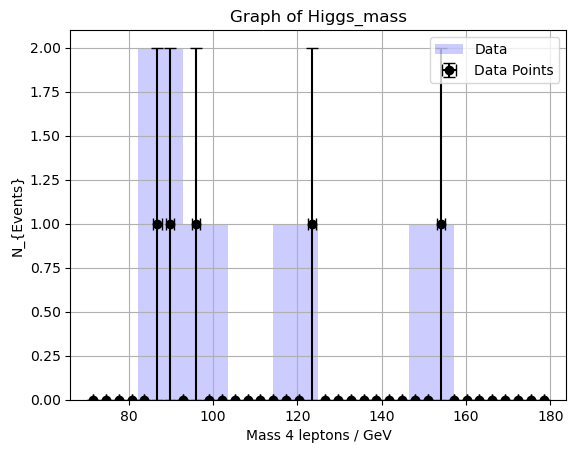

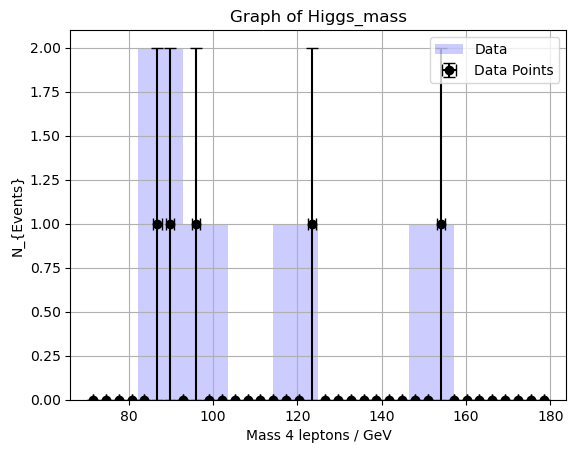

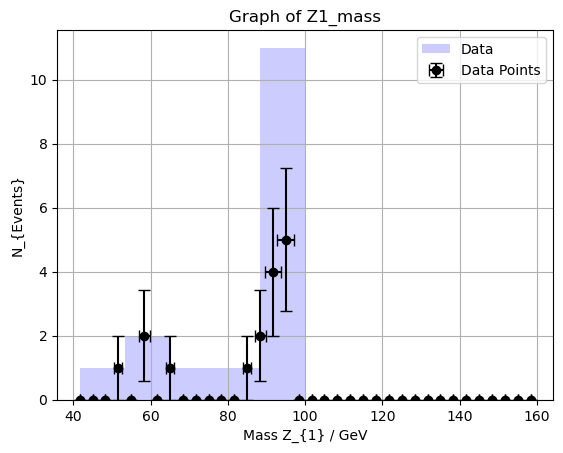

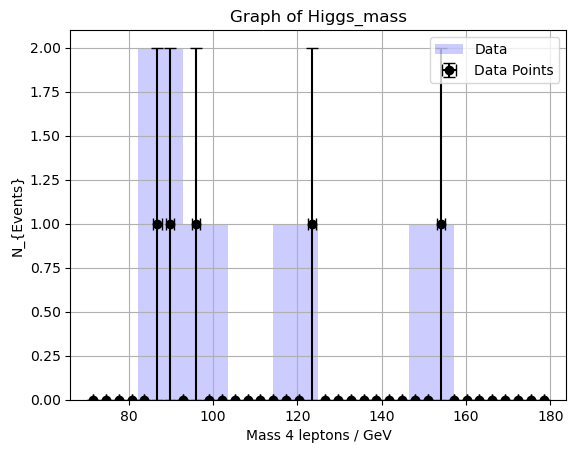

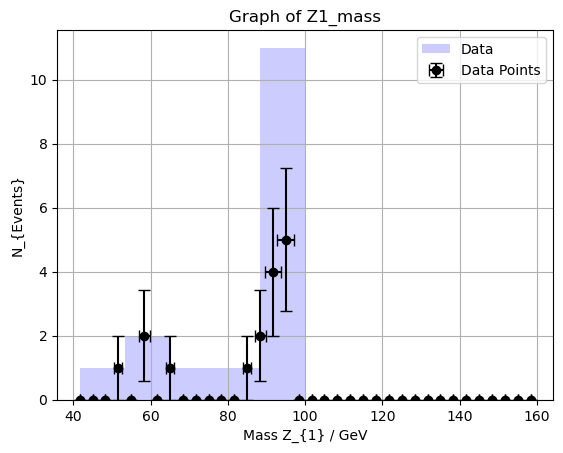

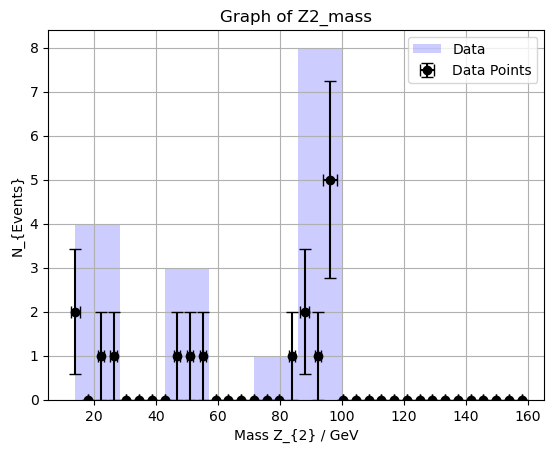

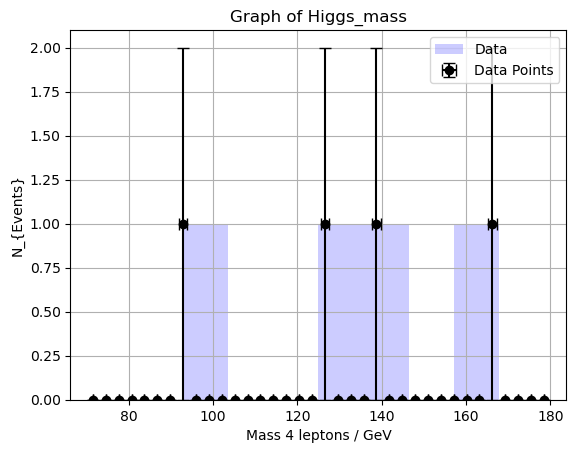

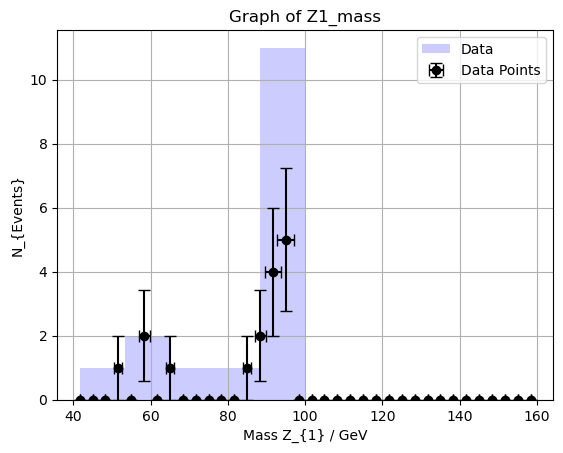

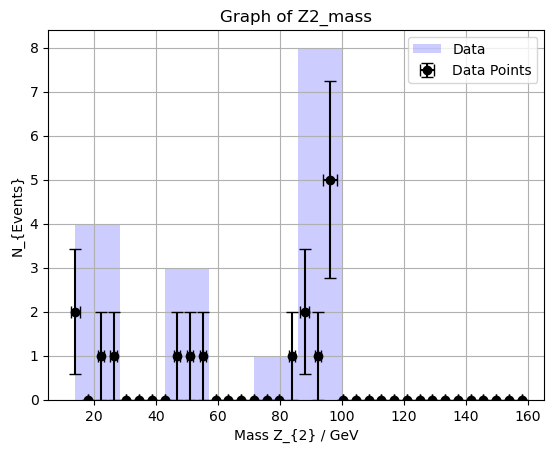

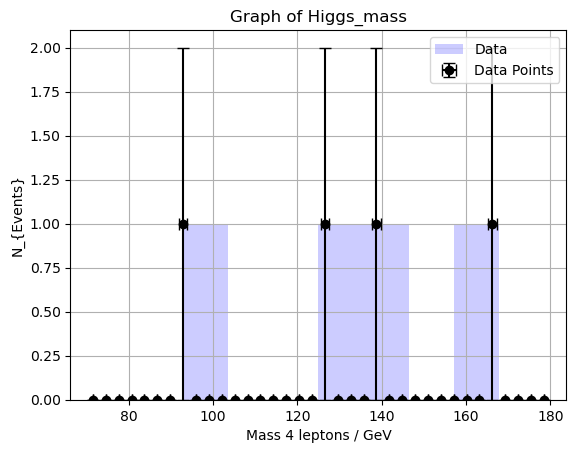

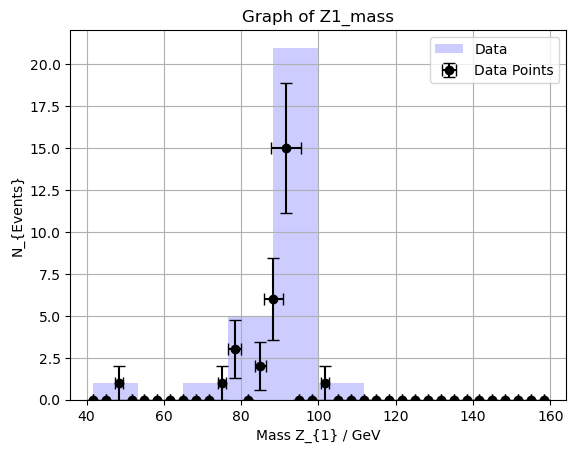

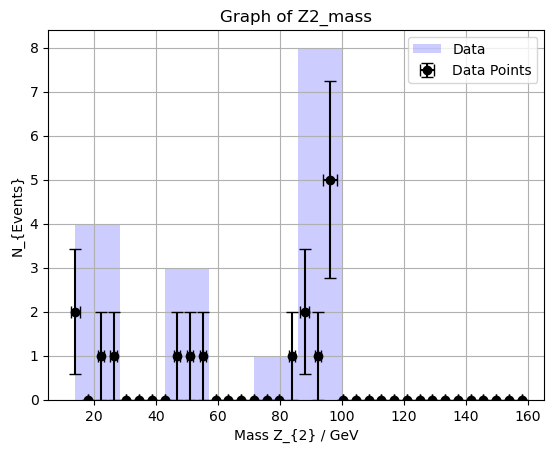

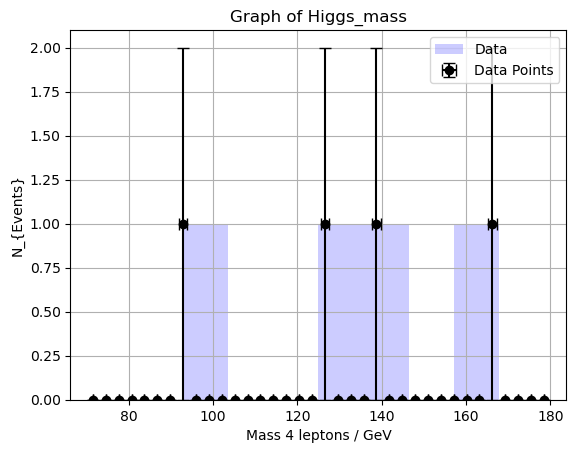

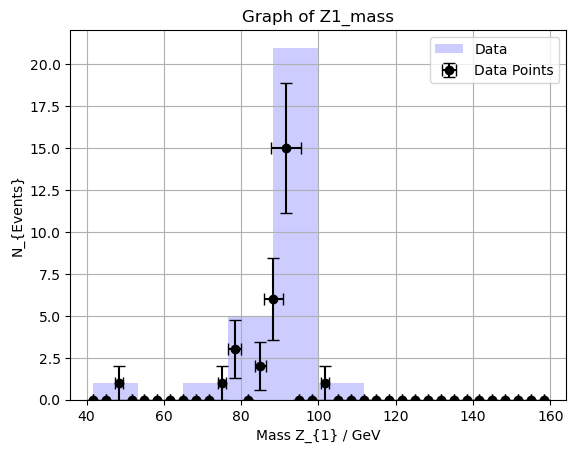

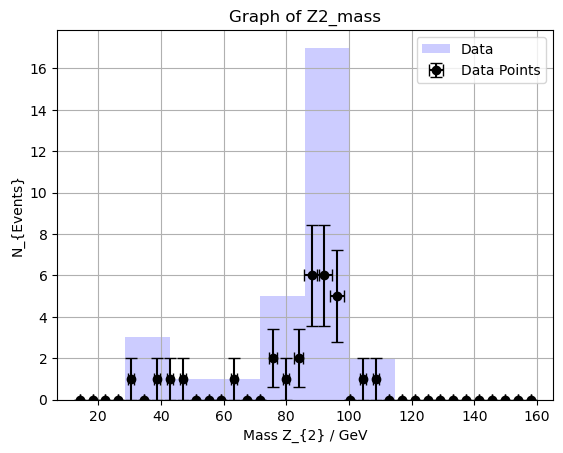

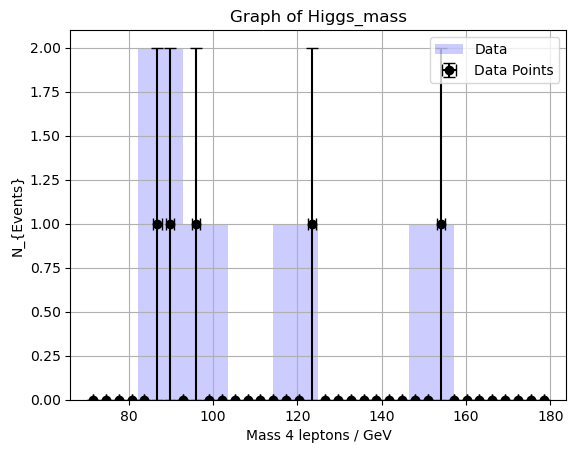

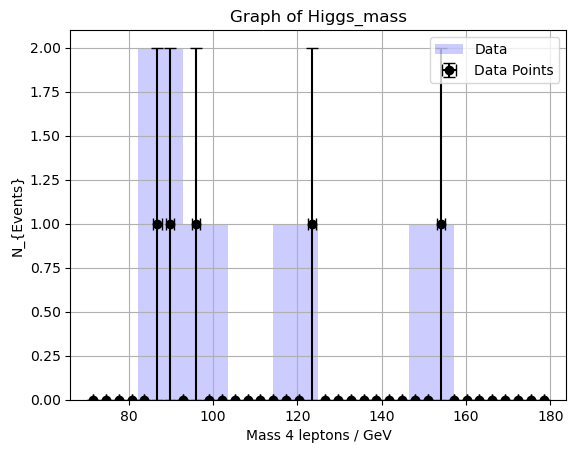

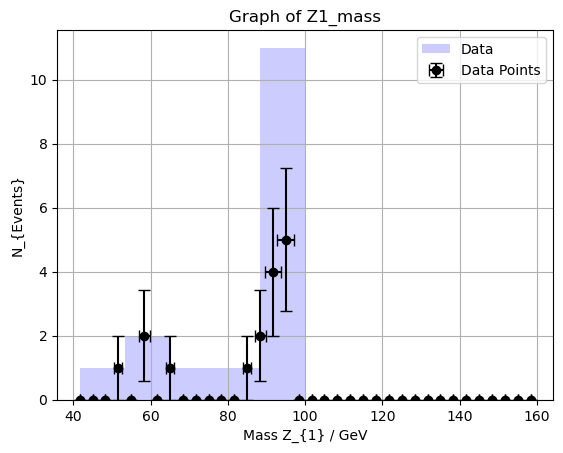

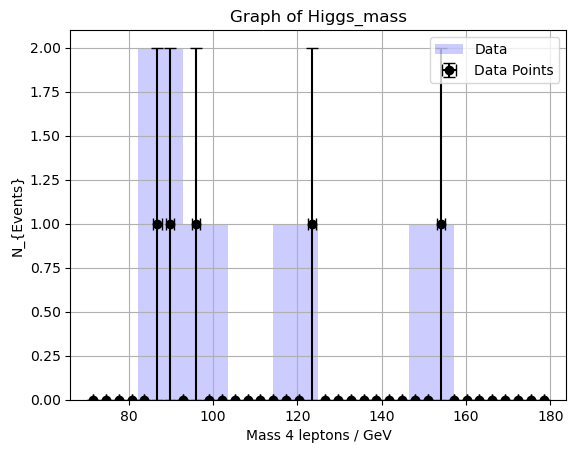

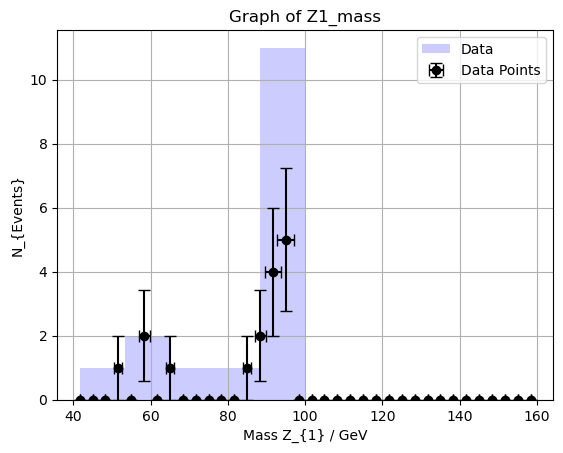

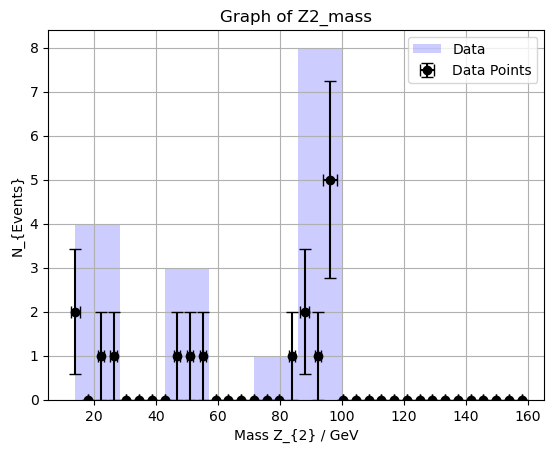

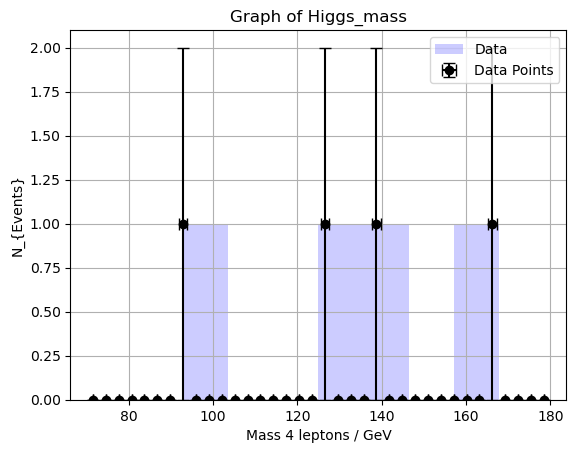

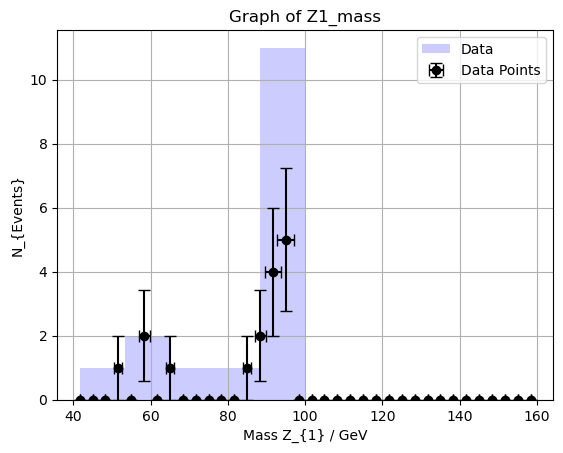

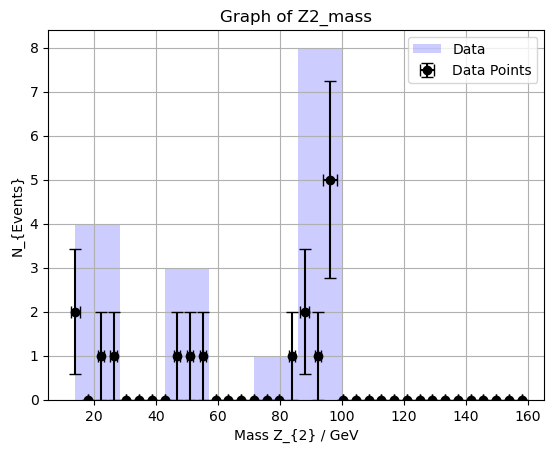

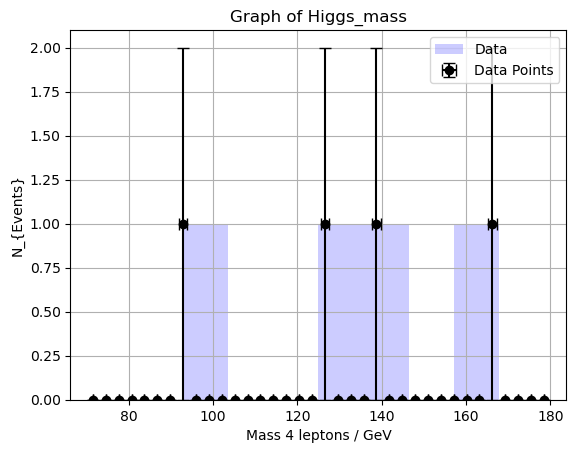

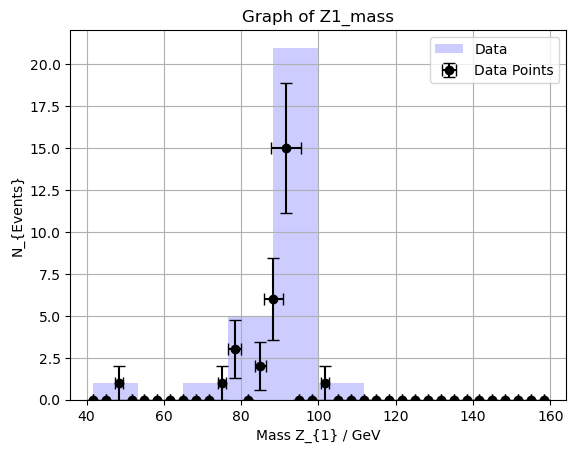

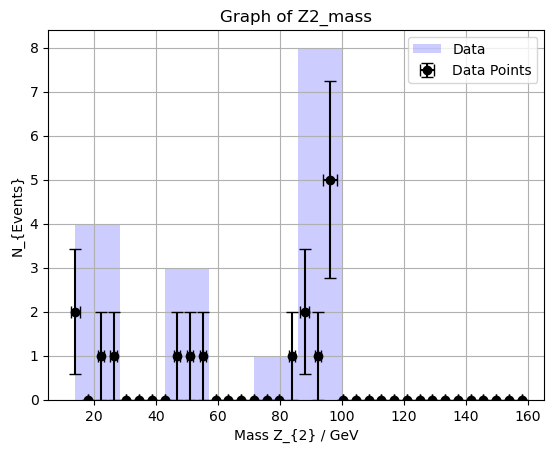

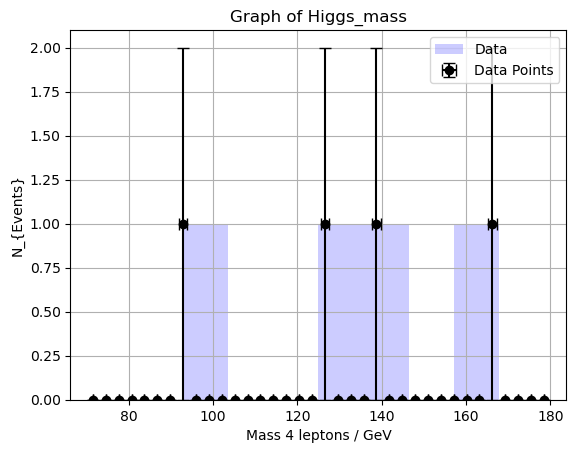

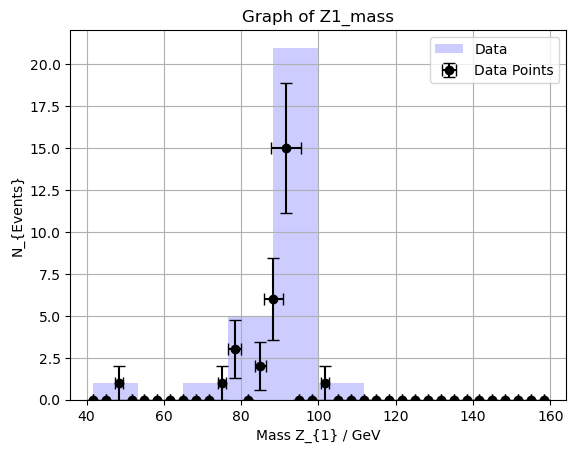

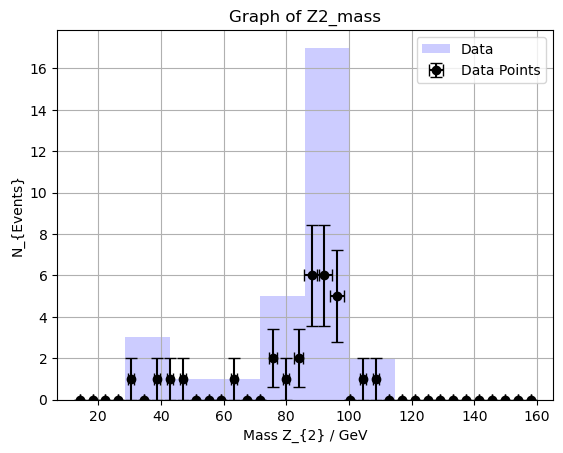

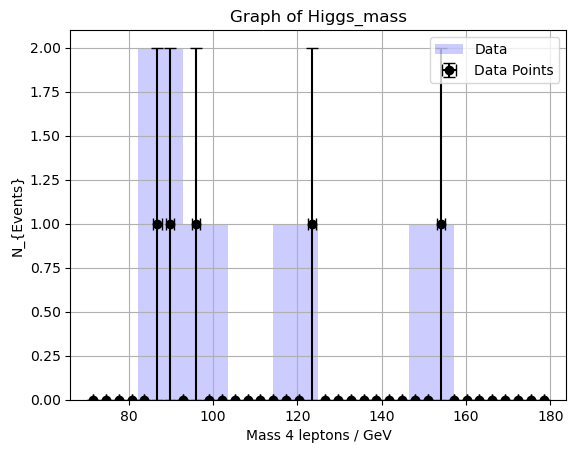

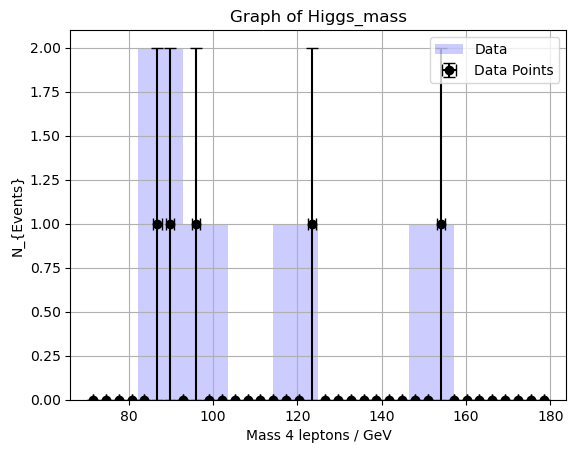

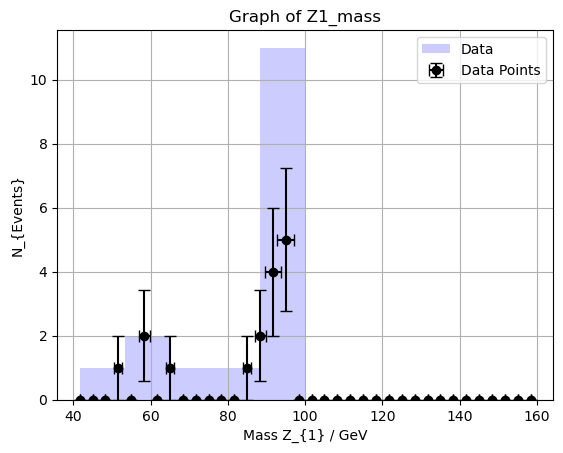

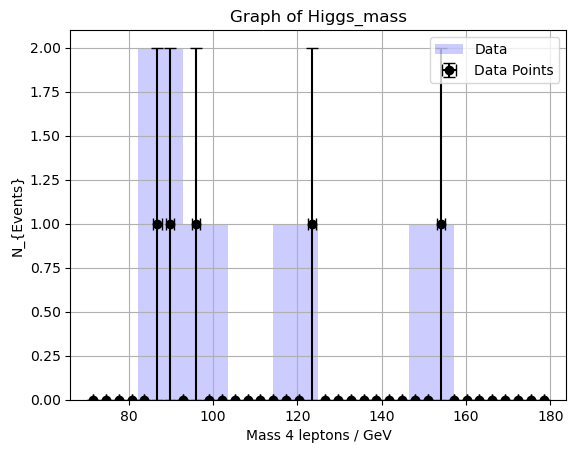

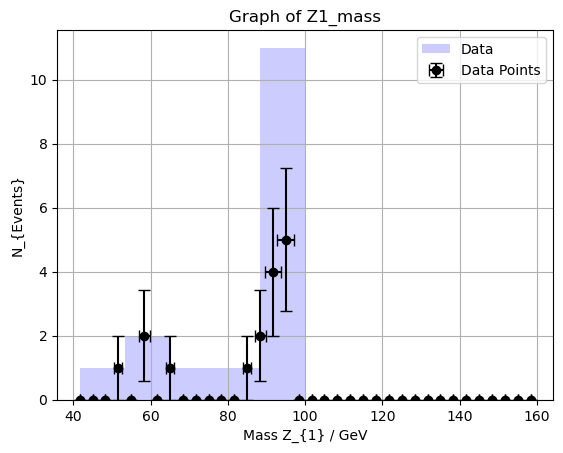

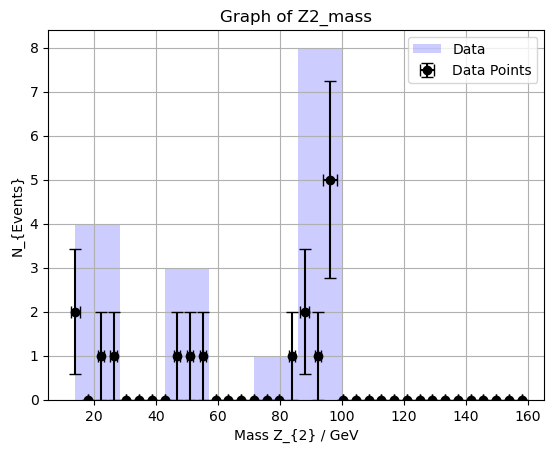

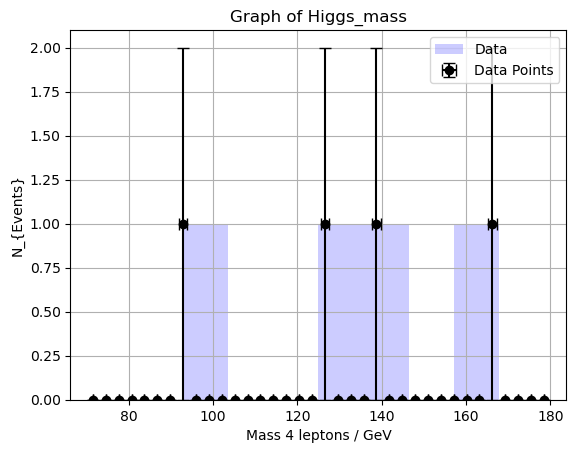

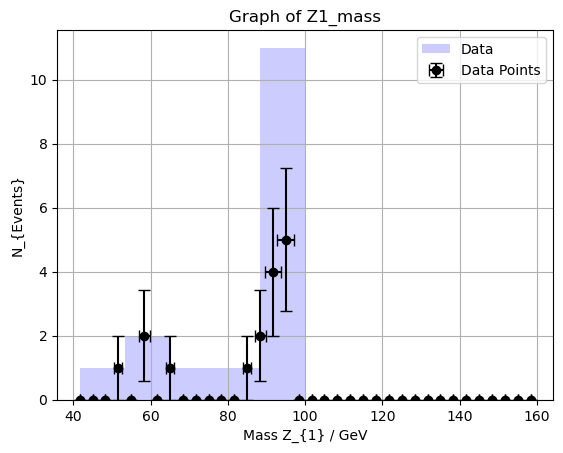

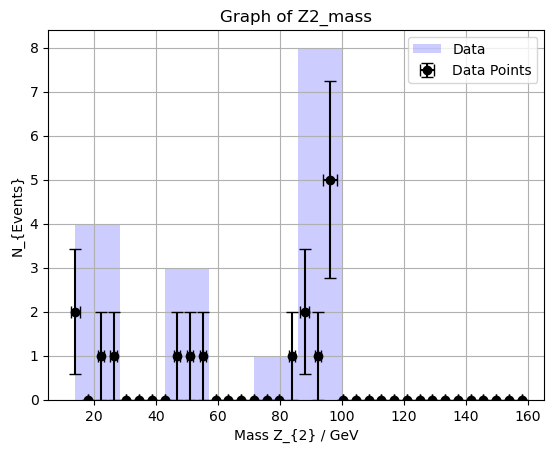

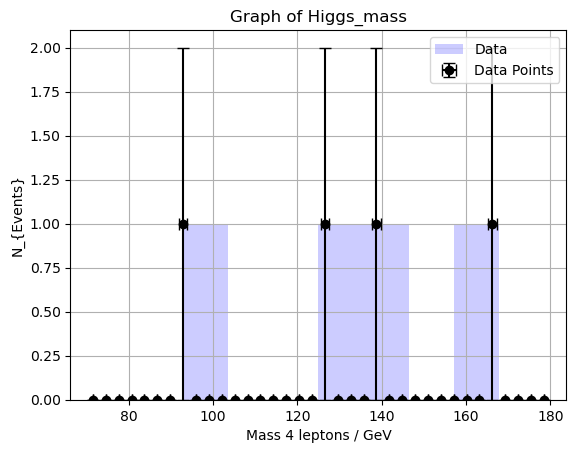

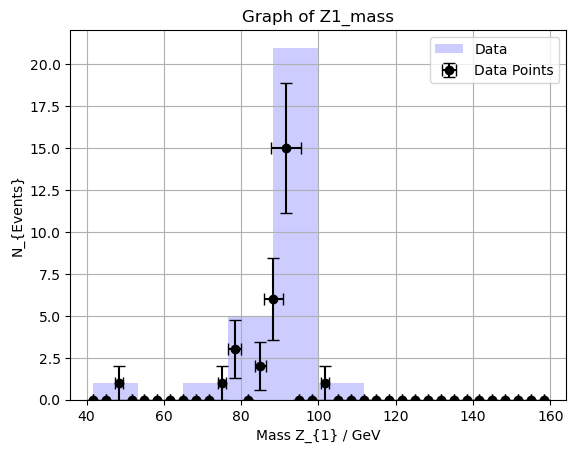

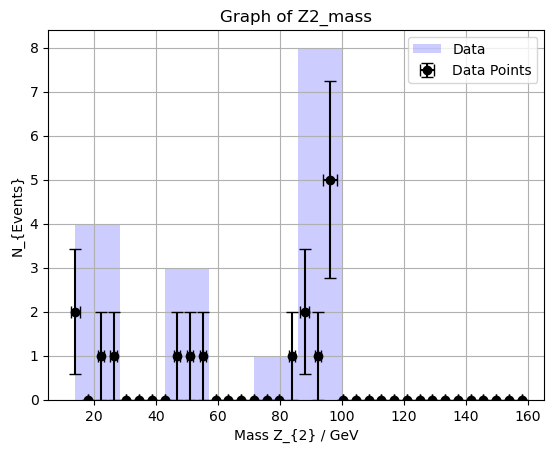

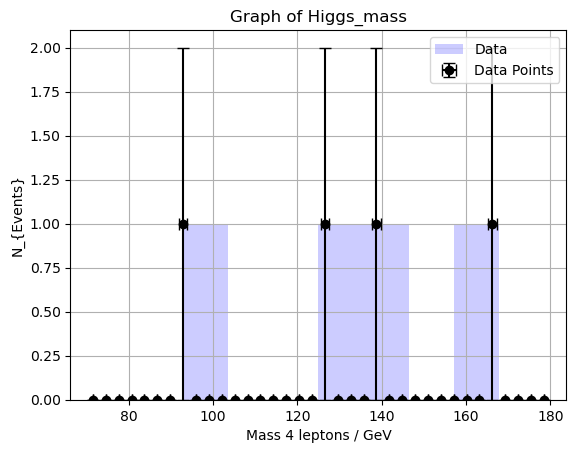

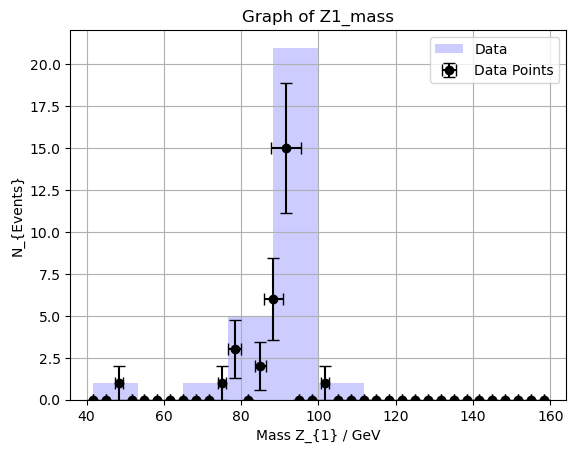

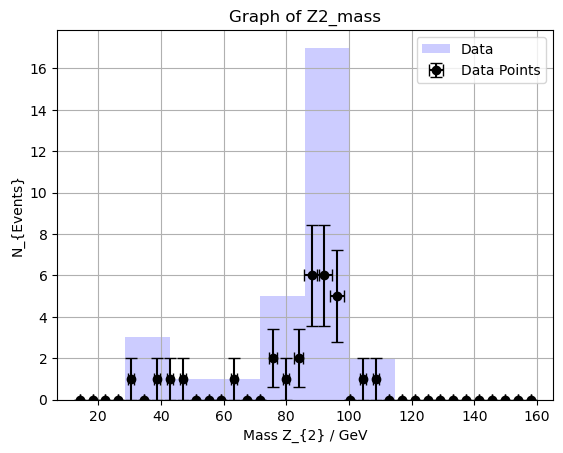

In [47]:
import matplotlib.pyplot as plt
# Declare a human-readable label for each variable on the plot axis
variable_labels = {
    "Higgs_mass": "Mass 4 leptons / GeV",
    "Z1_mass": "Mass Z_{1} / GeV",
    "Z2_mass": "Mass Z_{2} / GeV",
}


# Main function of the plotting step
def main(variable):
    # Load histograms from the input file
    histograms = {}
    for final_state, samples in [["FourElectrons", "Run2012B_DoubleElectron"], ["TwoMuonsTwoElectrons", "Run2012B_DoubleElectron"]]:
        for variable in variable_labels.keys():
            file_name = "{}_{}_{}.txt".format(samples, final_state, variable)
            data = pd.read_csv(file_name, delim_whitespace=True, header=0, names=["BinCenter", "BinContent"])
            histograms[variable] = data

            # Plot histograms
            for variable, data in histograms.items():
                plt.figure()
                plt.hist(data["BinCenter"], bins=10, weights=data["BinContent"], label="Data",color="blue", linewidth=2, alpha=0.2)
                 
              # Plot data points with error bars
                plt.errorbar(data["BinCenter"], data["BinContent"], xerr=np.sqrt(data["BinContent"]), yerr=np.sqrt(data["BinContent"]), fmt='o', color='black', label='Data Points', capsize=4, capthick=1)
                
                plt.xlabel(variable_labels[variable])
                plt.ylabel("N_{Events}")
                plt.title(f"Graph of {variable}")
                plt.legend()
                plt.grid(True)
                plt.savefig("{}_{}_{}.png".format(samples, final_state, variable))
                plt.show()

# Loop over all variable names and make a plot for each
if __name__ == "__main__":
    for variable in variable_labels.keys():
        main(variable)


## Predicción mediante el árbol de decisión obtenido con las medias de los valores del dataframe. 
Se obtienen predicciones satisfactorias y prometedoras.

### Caso FourElectrons

In [40]:
df_total_final = df_total.copy()

In [41]:
df_total

,run,luminosityBlock,event,PV_npvs,PV_x,PV_y,PV_z,nMuon,Muon_pt,Muon_eta,...,Electron_phi,Electron_mass,Electron_charge,Electron_pfRelIso03_all,Electron_dxy,Electron_dxyErr,Electron_dz,Electron_dzErr,MET_pt,MET_phi
0,194533,681,873825341.0,18,0.071257,0.059622,2.981453,0,[],[],...,"[-1.8246757, 0.43365964, 2.6529918, -0.9367162]","[0.013787657, 0.025002854, 0.0020841614, 0.002...","[1, 1, -1, -1]","[0.019024622, 0.014461898, 0.020648323, 0.1560...","[-0.0011017893, 0.0042656055, -0.008948063, -0...","[0.0041130837, 0.0032615487, 0.0135641955, 0.0...","[-0.0022092194, 0.0016150846, 0.0053586755, 0....","[0.0049048006, 0.0032565792, 0.01194281, 0.012...",44.491478,-1.808463
1,195378,458,579338428.0,8,0.077927,0.060684,-0.473797,0,[],[],...,"[-2.7004707, 1.9159746, 0.43017304, -1.7790967]","[-0.011484523, 0.007249524, -0.05366559, 0.017...","[1, -1, 1, -1]","[0.0, 0.12893748, 0.011190872, 0.16467507]","[-0.004122312, -0.0024617338, 0.0059019206, 0....","[0.0019549348, 0.0025381595, 0.004254095, 0.04...","[-0.0048166285, -0.0048590545, -0.0044550844, ...","[0.002120483, 0.0036224339, 0.0039096307, 0.01...",11.934087,-1.735179
2,195656,85,78300349.0,13,0.071539,0.061082,1.749452,1,[12.565105],[-1.084058],...,"[-2.2635484, -0.38645986, -2.6594787, 1.8108158]","[-0.01440676, -0.01337551, -0.016101446, 0.018...","[1, -1, 1, -1]","[0.154256, 0.09579001, 0.10296979, 0.07960164]","[0.0015929614, -0.0039971946, -0.0037480262, -...","[0.0023154812, 0.0025624472, 0.0018053487, 0.0...","[-0.00074468745, 0.00044963553, 0.0076586786, ...","[0.001250431, 0.0026983675, 0.0044744215, 0.00...",34.483574,-2.489217
3,194119,190,168130224.0,10,0.070204,0.058709,-4.365126,0,[],[],...,"[-1.2657838, 1.3154718, 1.6413988, -2.1798313]","[0.010927258, 0.02429796, 0.010789738, 0.03827...","[1, -1, -1, 1]","[0.03329212, 0.023840731, 0.027388094, 0.03918...","[0.0043120948, -0.00037497046, -0.0015002495, ...","[0.0039789747, 0.0015699519, 0.0019931206, 0.0...","[0.0019255406, 0.0005105451, 0.0009847987, -0....","[0.006290284, 0.0018522786, 0.0021433362, 0.00...",13.359872,-2.977974
4,194153,100,93572313.0,5,0.069637,0.063436,-5.211185,0,[],[],...,"[0.48001957, 2.60882, -2.308214, 1.7644149]","[-0.021255195, 0.010745706, -0.019129397, -0.0...","[-1, 1, -1, 1]","[0.046691235, 0.08974397, 0.046997555, 0.13117...","[-0.0021296884, 0.0005344796, 0.008963458, -0....","[0.0026694282, 0.0014937839, 0.0028750957, 0.0...","[-0.0030736378, -0.0042718137, 0.0026443065, 0...","[0.0045216125, 0.0024249929, 0.002111039, 0.00...",5.346667,2.566227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,195774,295,523206307.0,16,0.074584,0.061632,-0.282351,2,"[42.08680725097656, 9.121392250061035]","[-2.387733221054077, -2.3854429721832275]",...,[-0.271391361951828],[-0.04804345965385437],[1],[-999.0],[0.4654267132282257],[0.0045874714851379395],[-1.9727015495300293],[0.03133738413453102],9.495475,-3.020550
1041,196218,549,806278524.0,18,0.068448,0.063352,9.895555,0,[],[],...,[2.3533952236175537],[-0.003039397532120347],[-1],[0.5996907949447632],[-0.006164260674268007],[0.0032050558365881443],[0.1382865160703659],[0.004543033894151449],25.125383,-2.054347
1042,194108,468,460287914.0,18,0.073153,0.063125,-0.451324,0,[],[],...,[-0.3718331754207611],[-0.09590190649032593],[1],[-999.0],[0.5355864763259888],[0.03122222237288952],[-0.5158143043518066],[0.04117405042052269],13.151533,2.089058
1043,195950,1012,928809097.0,6,0.074352,0.062026,-1.547604,2,"[4.447993755340576, 3.083688974380493]","[2.2445881366729736, 2.4521405696868896]",...,"[-1.84910249710083, 2.050194025039673]","[0.033555105328559875, -0.01612236723303795]","[-1, 1]","[0.0121909836307168, 0.027822179719805717]","[-0.005058048292994499, 0.0042524621821939945]","[0.0026394538581371307, 0.003258243901655078]","[0.00012045018229400739, 0.005727317649871111]","[0.004368576221168041, 0.004354183096438646]",26.735487,3.064695


In [42]:
def transformar_lista(lista):
    if len(lista) > 0:
        return lista.to_list()  
    else:
        return lista.to_list() + [0]   

# Nombres de las columnas con listas
columnas_con_listas = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 
                       'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 
                       'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 
                       'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 
                       'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all']

# Aplicar la función de ajuste de longitud a cada columna con listas
for columna in columnas_con_listas:
    df_total[columna] = df_total[columna].apply(transformar_lista)

In [43]:
columns_with_lists = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 
                       'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 
                       'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 
                       'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 
                       'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all']
# Iterar sobre las filas del DataFrame original
for index, row in df_total.iterrows():
    for column in columns_with_lists:
        if isinstance(row[column], list):  # Verificar si la columna contiene una lista
            # Calcular la media de los valores en la lista
            mean_value = sum(row[column]) / len(row[column])
            # Actualizar el valor en el DataFrame original con la media
            df_total.at[index, column] = mean_value

# Imprimir el DataFrame de medias
df_total

,run,luminosityBlock,event,PV_npvs,PV_x,PV_y,PV_z,nMuon,Muon_pt,Muon_eta,...,Electron_phi,Electron_mass,Electron_charge,Electron_pfRelIso03_all,Electron_dxy,Electron_dxyErr,Electron_dz,Electron_dzErr,MET_pt,MET_phi
0,194533,681,873825341.0,18,0.071257,0.059622,2.981453,0,0.0,0.0,...,0.081315,0.010867,0.0,0.052545,-0.018229,0.00967,0.006625,0.008078,44.491478,-1.808463
1,195378,458,579338428.0,8,0.077927,0.060684,-0.473797,0,0.0,0.0,...,-0.533355,-0.010032,0.0,0.076201,0.025494,0.014527,-0.011628,0.006532,11.934087,-1.735179
2,195656,85,78300349.0,13,0.071539,0.061082,1.749452,1,12.565105,-1.084058,...,-0.874668,-0.006455,0.0,0.108154,-0.001842,0.002009,0.002047,0.002557,34.483574,-2.489217
3,194119,190,168130224.0,10,0.070204,0.058709,-4.365126,0,0.0,0.0,...,-0.122186,0.021074,0.0,0.030927,0.002952,0.002491,0.00073,0.003711,13.359872,-2.977974
4,194153,100,93572313.0,5,0.069637,0.063436,-5.211185,0,0.0,0.0,...,0.63626,-0.008623,0.0,0.078653,0.001469,0.002589,-0.000969,0.002621,5.346667,2.566227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,195774,295,523206307.0,16,0.074584,0.061632,-0.282351,2,25.6041,-2.386588,...,-0.271391,-0.048043,1.0,-999.0,0.465427,0.004587,-1.972702,0.031337,9.495475,-3.020550
1041,196218,549,806278524.0,18,0.068448,0.063352,9.895555,0,0.0,0.0,...,2.353395,-0.003039,-1.0,0.599691,-0.006164,0.003205,0.138287,0.004543,25.125383,-2.054347
1042,194108,468,460287914.0,18,0.073153,0.063125,-0.451324,0,0.0,0.0,...,-0.371833,-0.095902,1.0,-999.0,0.535586,0.031222,-0.515814,0.041174,13.151533,2.089058
1043,195950,1012,928809097.0,6,0.074352,0.062026,-1.547604,2,3.765841,2.348364,...,0.100546,0.008716,0.0,0.020007,-0.000403,0.002949,0.002924,0.004361,26.735487,3.064695


In [44]:
df_total1 = df_total.copy()

In [45]:
import joblib  # Importa joblib para cargar el modelo

# Carga el modelo de árbol de decisión desde el archivo
modelo = joblib.load("modelo_arbol_decision3.pkl")  # Ajusta el nombre del archivo según sea necesario

# Realiza predicciones en el DataFrame
predicciones = modelo.predict(df_total1)  # Realiza las predicciones en el DataFrame

# Agrega las predicciones al DataFrame
df_total1['Origin'] = predicciones  

# # Guarda el DataFrame con las etiquetas predichas
# df_total2.to_csv("df_etiquetado_TwoMuonsTwoElectrons.csv", index=False)  # Ajusta el nombre del archivo de salida según sea necesario

C:\Users\rlope\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [46]:
df_filtrado1 = df_total1[df_total1['Origin']==0]

In [47]:
len(df_filtrado1)

30

In [48]:
# Función para ajustar la longitud de las listas a 4 elementos
def transformar_lista(lista):
    if len(lista) > 0:
        return lista.to_list()  
    else:
        return lista.to_list() + [0]   

# Nombres de las columnas con listas
columnas_con_listas = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 
                       'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 
                       'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 
                       'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 
                       'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all']

# Aplicar la función de ajuste de longitud a cada columna con listas
for columna in columnas_con_listas:
    df1[columna] = df1[columna].apply(transformar_lista)

In [49]:
columns_with_lists = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 
                       'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 
                       'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 
                       'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 
                       'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all']
# Iterar sobre las filas del DataFrame original
for index, row in df1.iterrows():
    for column in columns_with_lists:
        if isinstance(row[column], list):  # Verificar si la columna contiene una lista
            # Calcular la media de los valores en la lista
            mean_value = sum(row[column]) / len(row[column])
            # Actualizar el valor en el DataFrame original con la media
            df1.at[index, column] = mean_value

# Imprimir el DataFrame de medias
df1

,run,luminosityBlock,event,PV_npvs,PV_x,PV_y,PV_z,nMuon,Muon_pt,Muon_eta,...,Electron_phi,Electron_mass,Electron_charge,Electron_pfRelIso03_all,Electron_dxy,Electron_dxyErr,Electron_dz,Electron_dzErr,MET_pt,MET_phi
0,194533,681,873825341,18,0.071257,0.059622,2.981453,0,0.0,0.0,...,0.081315,0.010867,0.0,0.052545,-0.018229,0.00967,0.006625,0.008078,44.491478,-1.808463
1,195378,458,579338428,8,0.077927,0.060684,-0.473797,0,0.0,0.0,...,-0.533355,-0.010032,0.0,0.076201,0.025494,0.014527,-0.011628,0.006532,11.934087,-1.735179
2,195656,85,78300349,13,0.071539,0.061082,1.749452,1,12.565105,-1.084058,...,-0.874668,-0.006455,0.0,0.108154,-0.001842,0.002009,0.002047,0.002557,34.483574,-2.489217
3,194119,190,168130224,10,0.070204,0.058709,-4.365126,0,0.0,0.0,...,-0.122186,0.021074,0.0,0.030927,0.002952,0.002491,0.00073,0.003711,13.359872,-2.977974
4,194153,100,93572313,5,0.069637,0.063436,-5.211185,0,0.0,0.0,...,0.63626,-0.008623,0.0,0.078653,0.001469,0.002589,-0.000969,0.002621,5.346667,2.566227
5,194479,345,402600389,12,0.072477,0.061877,4.169948,0,0.0,0.0,...,0.332248,0.013489,0.0,0.094063,0.002394,0.00265,0.003078,0.002868,22.844591,-0.556837
6,196531,350,497827501,16,0.069498,0.065866,-7.475705,0,0.0,0.0,...,-0.447987,-0.006464,0.0,0.185821,0.002253,0.004335,0.001093,0.003676,20.339300,0.472667
7,194480,122,109881951,16,0.072097,0.064309,7.587046,0,0.0,0.0,...,-0.62084,-0.003559,0.0,0.121877,0.000434,0.002323,-0.002591,0.002855,33.604733,-0.434116
8,194912,735,1149504856,9,0.072047,0.063586,0.419828,0,0.0,0.0,...,-0.06151,0.001988,0.0,0.159164,0.036701,0.052116,0.029747,0.0454,12.428426,-2.357242
9,195304,962,1069824602,13,0.072671,0.064566,-2.572178,0,0.0,0.0,...,-0.312582,0.025193,0.0,0.113893,-0.001209,0.003427,0.000911,0.004033,24.325714,-2.208419


In [50]:
shared_rows = pd.merge(df1, df_filtrado1, how='inner')
if not shared_rows.empty:
    print("Los DataFrames comparten filas.")
else:
    print("Los DataFrames no comparten filas.")

Los DataFrames comparten filas.


In [51]:
len(shared_rows)

16

### Caso TwoMuonsTwoElectrons

In [52]:
df_total2 = df_total.copy()

In [53]:
import joblib  # Importa joblib para cargar el modelo

# Carga el modelo de árbol de decisión desde el archivo
modelo = joblib.load("modelo_arbol_decision4.pkl")  # Ajusta el nombre del archivo según sea necesario

# Realiza predicciones en el DataFrame
predicciones = modelo.predict(df_total2)  # Realiza las predicciones en el DataFrame

# Agrega las predicciones al DataFrame
df_total2['Origin'] = predicciones  # Ajusta el nombre de la columna según sea necesario

# # Guarda el DataFrame con las etiquetas predichas
# df_total2.to_csv("df_etiquetado_TwoMuonsTwoElectrons.csv", index=False)  # Ajusta el nombre del archivo de salida según sea necesario

C:\Users\rlope\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [54]:
df_filtrado2 = df_total2[df_total2['Origin']==0]

In [55]:
len(df_filtrado2)

61

In [56]:
# Función para ajustar la longitud de las listas a 4 elementos
def transformar_lista(lista):
    if len(lista) > 0:
        return lista.to_list()  
    else:
        return lista.to_list() + [0]   

# Nombres de las columnas con listas
columnas_con_listas = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 
                       'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 
                       'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 
                       'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 
                       'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all']

# Aplicar la función de ajuste de longitud a cada columna con listas
for columna in columnas_con_listas:
    df2[columna] = df2[columna].apply(transformar_lista)

In [57]:
columns_with_lists = ['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge', 'Muon_dxy', 
                       'Muon_dxyErr', 'Muon_dz', 'Muon_dzErr', 'Muon_pfRelIso03_all', 
                       'Muon_pfRelIso04_all', 'Electron_pt', 'Electron_eta', 'Electron_phi', 
                       'Electron_mass', 'Electron_charge', 'Electron_dxy', 'Electron_dxyErr', 
                       'Electron_dz', 'Electron_dzErr', 'Electron_pfRelIso03_all']
# Iterar sobre las filas del DataFrame original
for index, row in df2.iterrows():
    for column in columns_with_lists:
        if isinstance(row[column], list):  # Verificar si la columna contiene una lista
            # Calcular la media de los valores en la lista
            mean_value = sum(row[column]) / len(row[column])
            # Actualizar el valor en el DataFrame original con la media
            df2.at[index, column] = mean_value

# Imprimir el DataFrame de medias
df2

,run,luminosityBlock,event,PV_npvs,PV_x,PV_y,PV_z,nMuon,Muon_pt,Muon_eta,...,Electron_phi,Electron_mass,Electron_charge,Electron_pfRelIso03_all,Electron_dxy,Electron_dxyErr,Electron_dz,Electron_dzErr,MET_pt,MET_phi
0,195147,465,567117841,15,0.069283,0.060425,1.488094,2,67.175291,-0.852322,...,2.239363,0.013779,0.0,0.024693,0.000677,0.002351,-0.003542,0.002843,17.840918,-0.329279
1,195115,21,18955331,16,0.072382,0.064840,-8.422611,2,74.248724,0.304922,...,1.644495,-0.013946,0.0,0.018824,-0.002248,0.001367,-0.000633,0.002123,30.565094,-3.040239
2,196438,969,831731260,10,0.070965,0.061411,-1.296511,2,43.144247,-1.088991,...,0.982132,0.00857,0.0,-999.0,0.145588,0.052345,0.455352,0.792585,17.980923,-1.867973
3,195530,137,215099909,12,0.073218,0.063174,-2.387559,2,145.195154,0.795999,...,2.784087,0.017257,0.0,0.052276,-0.001198,0.002372,-0.003715,0.00382,19.548065,1.512442
4,196218,296,446438292,14,0.071620,0.062773,-6.864948,2,50.158665,1.819497,...,0.562196,0.012238,0.0,0.062899,0.001888,0.004547,-0.005965,0.003663,26.886530,-0.960766
5,195378,296,372893489,12,0.075019,0.066310,3.148372,2,53.570189,-1.296835,...,0.425568,0.029006,0.0,-499.474475,-0.005086,0.004224,0.005213,0.007349,20.153877,-0.378769
6,194050,954,900261478,7,0.071081,0.062809,-0.723120,2,44.393734,-1.726867,...,-0.033441,-0.010285,0.0,-999.0,-0.001642,0.002406,0.003944,0.003841,30.114784,-1.782306
7,195398,66,53211301,8,0.072800,0.064317,-5.997319,2,62.544857,-0.601119,...,-2.587191,0.020399,0.0,0.065907,-0.002502,0.003809,-0.003805,0.00416,10.532579,-0.408803
8,196203,18,14865328,11,0.074257,0.063126,0.338309,2,22.98169,-1.735388,...,1.26216,-0.010275,0.0,-999.0,0.001493,0.005819,0.002935,0.006761,20.714985,0.402728
9,196453,1337,1181788896,17,0.072128,0.062404,-1.734727,2,23.356506,-0.867332,...,-1.465378,0.015132,0.0,0.056308,-0.002042,0.003534,-0.002113,0.006643,19.274158,-1.781538


In [58]:
shared_rows = pd.merge(df2, df_filtrado2, how='inner')
if not shared_rows.empty:
    print("Los DataFrames comparten filas.")
else:
    print("Los DataFrames no comparten filas.")

Los DataFrames comparten filas.


In [59]:
len(shared_rows)

29

### Matrices de confusión

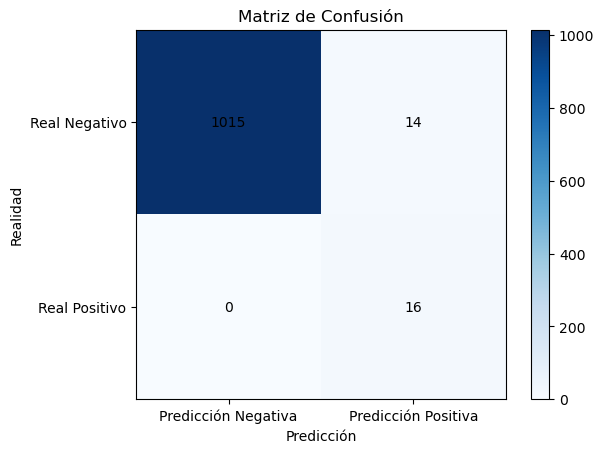

In [60]:
import matplotlib.pyplot as plt
# Definimos los nuevos valores de la matriz de confusión
verdaderos_positivos = 16
verdaderos_negativos = 1015
falsos_positivos = 14
falsos_negativos = 0

# Creamos la nueva matriz de confusión
confusion_matrix = np.array([[verdaderos_negativos, falsos_positivos],
                             [falsos_negativos, verdaderos_positivos]])

# Graficamos la nueva matriz de confusión
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Añadimos etiquetas
plt.xticks([0, 1], ['Predicción Negativa', 'Predicción Positiva'])
plt.yticks([0, 1], ['Real Negativo', 'Real Positivo'])

# Añadimos los valores de la matriz en cada celda
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

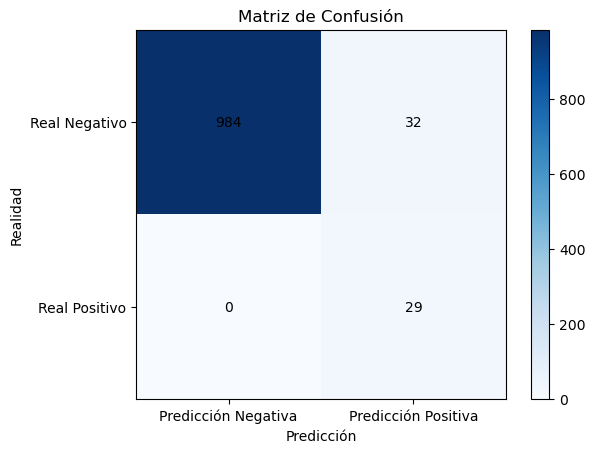

In [61]:
verdaderos_positivos = 29
verdaderos_negativos = 984
falsos_positivos = 32
falsos_negativos = 0

# Creamos la nueva matriz de confusión
confusion_matrix = np.array([[verdaderos_negativos, falsos_positivos],
                             [falsos_negativos, verdaderos_positivos]])

# Graficamos la nueva matriz de confusión
plt.imshow(confusion_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()

# Añadimos etiquetas
plt.xticks([0, 1], ['Predicción Negativa', 'Predicción Positiva'])
plt.yticks([0, 1], ['Real Negativo', 'Real Positivo'])

# Añadimos los valores de la matriz en cada celda
for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

### Obtención de las filas predichas por el Árbol de decisión para graficar

In [62]:
indices_filtrados1 = df_filtrado1.index

In [63]:
indices_filtrados1

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  74, 134, 407, 435, 445, 512, 608, 628, 695, 746, 833, 855,
       919, 954],
      dtype='int64')

In [64]:
# Usar el método loc para seleccionar las filas con los índices guardados en indices_filtrados1
df_seleccionado1 = df_total_final.loc[indices_filtrados1]

In [65]:
df_seleccionado1 = df_seleccionado1.reset_index()

In [66]:
df_seleccionado1

,index,run,luminosityBlock,event,PV_npvs,PV_x,PV_y,PV_z,nMuon,Muon_pt,...,Electron_phi,Electron_mass,Electron_charge,Electron_pfRelIso03_all,Electron_dxy,Electron_dxyErr,Electron_dz,Electron_dzErr,MET_pt,MET_phi
0,0,194533,681,8.738253e+08,18,0.071257,0.059622,2.981453,0,[],...,"[-1.8246757, 0.43365964, 2.6529918, -0.9367162]","[0.013787657, 0.025002854, 0.0020841614, 0.002...","[1, 1, -1, -1]","[0.019024622, 0.014461898, 0.020648323, 0.1560...","[-0.0011017893, 0.0042656055, -0.008948063, -0...","[0.0041130837, 0.0032615487, 0.0135641955, 0.0...","[-0.0022092194, 0.0016150846, 0.0053586755, 0....","[0.0049048006, 0.0032565792, 0.01194281, 0.012...",44.491478,-1.808463
1,1,195378,458,5.793384e+08,8,0.077927,0.060684,-0.473797,0,[],...,"[-2.7004707, 1.9159746, 0.43017304, -1.7790967]","[-0.011484523, 0.007249524, -0.05366559, 0.017...","[1, -1, 1, -1]","[0.0, 0.12893748, 0.011190872, 0.16467507]","[-0.004122312, -0.0024617338, 0.0059019206, 0....","[0.0019549348, 0.0025381595, 0.004254095, 0.04...","[-0.0048166285, -0.0048590545, -0.0044550844, ...","[0.002120483, 0.0036224339, 0.0039096307, 0.01...",11.934087,-1.735179
2,2,195656,85,7.830035e+07,13,0.071539,0.061082,1.749452,1,[12.565105],...,"[-2.2635484, -0.38645986, -2.6594787, 1.8108158]","[-0.01440676, -0.01337551, -0.016101446, 0.018...","[1, -1, 1, -1]","[0.154256, 0.09579001, 0.10296979, 0.07960164]","[0.0015929614, -0.0039971946, -0.0037480262, -...","[0.0023154812, 0.0025624472, 0.0018053487, 0.0...","[-0.00074468745, 0.00044963553, 0.0076586786, ...","[0.001250431, 0.0026983675, 0.0044744215, 0.00...",34.483574,-2.489217
3,3,194119,190,1.681302e+08,10,0.070204,0.058709,-4.365126,0,[],...,"[-1.2657838, 1.3154718, 1.6413988, -2.1798313]","[0.010927258, 0.02429796, 0.010789738, 0.03827...","[1, -1, -1, 1]","[0.03329212, 0.023840731, 0.027388094, 0.03918...","[0.0043120948, -0.00037497046, -0.0015002495, ...","[0.0039789747, 0.0015699519, 0.0019931206, 0.0...","[0.0019255406, 0.0005105451, 0.0009847987, -0....","[0.006290284, 0.0018522786, 0.0021433362, 0.00...",13.359872,-2.977974
4,4,194153,100,9.357231e+07,5,0.069637,0.063436,-5.211185,0,[],...,"[0.48001957, 2.60882, -2.308214, 1.7644149]","[-0.021255195, 0.010745706, -0.019129397, -0.0...","[-1, 1, -1, 1]","[0.046691235, 0.08974397, 0.046997555, 0.13117...","[-0.0021296884, 0.0005344796, 0.008963458, -0....","[0.0026694282, 0.0014937839, 0.0028750957, 0.0...","[-0.0030736378, -0.0042718137, 0.0026443065, 0...","[0.0045216125, 0.0024249929, 0.002111039, 0.00...",5.346667,2.566227
5,5,194479,345,4.026004e+08,12,0.072477,0.061877,4.169948,0,[],...,"[1.9162245, -0.8782573, 1.4903039, -1.1992797]","[0.027834274, 0.003159311, 0.0044234972, 0.018...","[1, -1, -1, 1]","[0.004545307, 0.06334454, 0.21119364, 0.09716801]","[0.0011378624, -0.0012562714, 0.0031810347, 0....","[0.001552851, 0.0028016355, 0.003097901, 0.003...","[-0.0019089332, 0.0041176206, -0.00097096147, ...","[0.0029686263, 0.002682678, 0.0019333627, 0.00...",22.844591,-0.556837
6,6,196531,350,4.978275e+08,16,0.069498,0.065866,-7.475705,0,[],...,"[-2.7338622, -0.3292558, 0.6225707, 0.6486]","[-0.008238616, -0.008678299, -0.0035384549, -0...","[1, -1, 1, -1]","[0.29273325, 0.1000301, 0.19530436, 0.15521815]","[0.0037852472, -0.0026033944, 0.00068560167, 0...","[0.0067054573, 0.00299633, 0.0037449673, 0.003...","[0.009773342, -0.001810088, -0.0040129283, 0.0...","[0.0044952566, 0.0023275164, 0.004287473, 0.00...",20.339300,0.472667
7,7,194480,122,1.098820e+08,16,0.072097,0.064309,7.587046,0,[],...,"[0.70492935, -2.9197075, 1.19319, -1.4617712]","[-0.011641212, -0.0026263422, -0.011454028, 0....","[1, -1, 1, -1]","[0.17921025, 0.12782222, 0.17076509, 0.0097093...","[0.0022277446, -0.002815029, 0.0036287503, -0....","[0.0025846735, 0.0024936472, 0.0019511041, 0.0...","[-0.013507767, 0.002769104, 0.0008754725, -0.0...","[0.0030868002, 0.002676441, 0.003149315, 0.002...",33.604733,-0.434116
8,8,194912,735,1.149505e+09,9,0.072047,0.063586,0.419828,0,[],...,"[1.760221

In [67]:
indices_filtrados2 = df_filtrado2.index

In [68]:
indices_filtrados2

Index([  16,   17,   18,   19,   20,   21,   22,   23,   24,   25,   26,   27,
         28,   29,   30,   31,   32,   33,   34,   35,   36,   37,   38,   39,
         40,   41,   42,   43,   44,   48,   53,  128,  212,  275,  278,  334,
        340,  388,  461,  548,  565,  586,  607,  620,  632,  664,  699,  713,
        728,  740,  791,  792,  800,  882,  906,  930,  954,  966,  968, 1040,
       1043],
      dtype='int64')

In [69]:
# Usar el método loc para seleccionar las filas con los índices guardados en indices_filtrados1
df_seleccionado2 = df_total_final.loc[indices_filtrados2]

In [70]:
df_seleccionado2 = df_seleccionado2.reset_index()

In [71]:
df_seleccionado2

,index,run,luminosityBlock,event,PV_npvs,PV_x,PV_y,PV_z,nMuon,Muon_pt,...,Electron_phi,Electron_mass,Electron_charge,Electron_pfRelIso03_all,Electron_dxy,Electron_dxyErr,Electron_dz,Electron_dzErr,MET_pt,MET_phi
0,16,195147,465,567117841.0,15,0.069283,0.060425,1.488094,2,"[27.23209, 107.11849]",...,"[3.08651, 1.3922164]","[0.021008335, 0.0065487097]","[1, -1]","[0.014866365, 0.034519892]","[-0.00031410492, 0.0016677965]","[0.0010764736, 0.0036247661]","[-0.002235216, -0.004848286]","[0.0014620811, 0.0042240215]",17.840918,-0.329279
1,17,195115,21,18955331.0,16,0.072382,0.064840,-8.422611,2,"[130.21037, 18.287075]",...,"[2.2274826, 1.061508]","[-0.017890545, -0.010001657]","[-1, 1]","[0.030510189, 0.0071372055]","[-0.0014591258, -0.0030376753]","[0.0013010614, 0.0014329265]","[-0.0010168456, -0.00024969474]","[0.0021941026, 0.0020511243]",30.565094,-3.040239
2,18,196438,969,831731260.0,10,0.070965,0.061411,-1.296511,2,"[57.979633, 28.30886]",...,"[1.8014891, 0.16277437]","[-0.004595331, 0.021734564]","[1, -1]","[-999.0, -999.0]","[-0.0011781832, 0.29235333]","[0.006127245, 0.098561846]","[0.0004135656, 0.91028947]","[0.00697489, 1.5781955]",17.980923,-1.867973
3,19,195530,137,215099909.0,12,0.073218,0.063174,-2.387559,2,"[238.36032, 52.029987]",...,"[2.872948, 2.6952252]","[-0.0032107823, 0.037724957]","[1, -1]","[0.07128746, 0.03326395]","[-0.0004983414, -0.0018968141]","[0.0030004818, 0.0017442644]","[-0.0024882567, -0.004941415]","[0.00407031, 0.0035690877]",19.548065,1.512442
4,20,196218,296,446438292.0,14,0.071620,0.062773,-6.864948,2,"[42.527637, 57.789692]",...,"[1.7942619, -0.6698701]","[0.031597123, -0.007120458]","[-1, 1]","[0.012920457, 0.112878054]","[-0.0025296237, 0.0063064294]","[0.0009565954, 0.008136662]","[-0.007878623, -0.004051558]","[0.003204111, 0.0041216128]",26.886530,-0.960766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,954,194789,208,280528623.0,17,0.069060,0.059324,8.067879,2,"[5.454460620880127, 3.579864025115967]",...,"[-1.9512187242507935, -1.535345435142517, 1.90...","[-0.0025221521500498056, -0.00540172727778554,...","[-1, 1, 1, 1]","[4.478725910186768, -999.0, -999.0, 1.68434965...","[-0.0027145794592797756, 0.0021656237076967955...","[0.005501835606992245, 0.0027845827862620354, ...","[-0.0011728823883458972, -0.003043859032914042...","[0.006353321950882673, 0.005821016151458025, 0...",47.694084,0.345765
57,966,194631,13,20081767.0,26,0.071403,0.062627,-2.960083,2,"[20.953550338745117, 41.32903289794922]",...,[0.3545739948749542],[0.13502873480319977],[-1],[0.029258323833346367],[0.0019112437730655074],[0.0020034098997712135],[-0.007565602660179138],[0.002904467983171344],48.544735,1.614024
58,968,194115,111,80177955.0,13,0.070199,0.064027,2.243201,2,"[4.932862758636475, 6.2752861976623535]",...,[-1.2575572729110718],[-0.016965508460998535],[1],[0.4202219843864441],[0.0019336933037266135],[0.0024321710225194693],[-0.0009849448688328266],[0.0029455129988491535],26.943090,2.041224
59,1040,195774,295,523206307.0,16,0.074584,0.061632,-0.282351,2,"[42.08680725097656, 9.121392250061035]",...,[-0.271391361951828],[-0.04804345965385437],[1],[-999.0],[0.4654267132282257],[0.0045874714851379395],[-1.9727015495300293],[0.03133738413453102],9.495475,-3.020550


### Calculo masas y gráfica

In [72]:
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

#Reconstrucción de los dos candidatos a bosón Z a partir de los 4 leptones del mismo tipo
def reconstruct_samekind(array):    
    z_mass = 91.2
    idx = np.zeros((2, 2), dtype=int)
    #Genera todas los pares de combinaciones posibles con el número de electrones que hay que serán 4
    pairs = list(combinations(range(len(array['Electron_pt'][0])), 2)) 
    z_idx = [] #lista donde guardar los índices de cada fila para crear una nueva columna en el dataframe
    for pt, eta, phi, mass, charge in zip(array['Electron_pt'],array['Electron_eta'],array['Electron_phi'],array['Electron_mass'],array['Electron_charge']): 
        # Encuentra el primer par de leptones con la masa invariante más cercana a la masa del bosón Z
        best_mass = -1
        for i1, i2 in pairs:
            if charge[i1] != charge[i2]:
               # Calcular componentes de energía y momento lineal para cada lepton
                energy1 = np.sqrt((pt[i1]*np.cosh(eta[i1]))**2 + mass[i1]**2)
                energy2 = np.sqrt((pt[i2]*np.cosh(eta[i2]))**2 + mass[i2]**2)
                px1 = pt[i1] * np.cos(phi[i1])
                py1 = pt[i1] * np.sin(phi[i1])
                pz1 = pt[i1] * np.sinh(eta[i1])
                px2 = pt[i2] * np.cos(phi[i2])
                py2 = pt[i2] * np.sin(phi[i2])
                pz2 = pt[i2] * np.sinh(eta[i2])

                # Calcular la masa invariante
                this_mass = np.sqrt((energy1 + energy2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2)
                if np.abs(z_mass - this_mass) < np.abs(z_mass - best_mass):
                    best_mass = this_mass
                    best_i1, best_i2 = i1, i2
        
        idx[0] = [best_i1, best_i2]
        # Reconstrucción del segundo bosón Z a partir del par de leptones restantes
        remaining_indices = [i for i in range(4) if i != best_i1 and i != best_i2]
        idx[1] = remaining_indices
        z_idx.append(idx.copy())
    return z_idx

In [73]:
z_idx = reconstruct_samekind(df_seleccionado1)

In [74]:
def calcular_energia_momento(pt, eta, phi, mass):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    energy = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
    return energy, px, py, pz

# Función para crear los cuadrivectores a partir de las componentes de energía y momento
def crear_cuadrivector(energy, px, py, pz):
    return np.array([energy, px, py, pz])

def calcular_masa_invariante(cuadrivector):
    energy = cuadrivector[0]
    momentum_modulus_squared = np.sum(cuadrivector[1:]**2)
    invariant_mass_squared = energy**2 - momentum_modulus_squared
    invariant_mass = np.sqrt(invariant_mass_squared)
    return invariant_mass

# Función principal para calcular los cuadrivectores de las partículas
def z_fourvectors_samekind(z_idx, array):
    lista_z_fourvecs = []
    z_mass = 91.2
    for fila in range(len(z_idx)):
        pt = array['Electron_pt'][fila]
        eta = array['Electron_eta'][fila]
        phi = array['Electron_phi'][fila]
        mass = array['Electron_mass'][fila]
        z_fourvecs = np.zeros((2, 4))  # Crear arreglo para almacenar cuadrivectores
        for i in range(2):
            i1 = z_idx[fila][i][0]
            i2 = z_idx[fila][i][1]
            energy1, px1, py1, pz1 = calcular_energia_momento(pt[i1], eta[i1], phi[i1], mass[i1])
            energy2, px2, py2, pz2 = calcular_energia_momento(pt[i2], eta[i2], phi[i2], mass[i2])
            cuadrivector = crear_cuadrivector(energy1 + energy2, px1 + px2, py1 + py2, pz1 + pz2)
            z_fourvecs[i] = cuadrivector

        # Ordenar cuadrivectores según proximidad a la masa del bosón Z
        if abs(calcular_masa_invariante(z_fourvecs[0]) - z_mass) < abs(calcular_masa_invariante(z_fourvecs[1]) - z_mass):
            lista_z_fourvecs.append(z_fourvecs)
        else:
            z_fourvecs = z_fourvecs[::-1]
            lista_z_fourvecs.append(z_fourvecs)

    return lista_z_fourvecs

In [75]:
lista_z_fourvecs1 = z_fourvectors_samekind(z_idx, df_seleccionado1)

In [76]:
# Función para calcular la energía y el momento de una partícula a partir de sus componentes
def calcular_energia_momento(pt, eta, phi, mass):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    energy = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
    return energy, px, py, pz

# Función para crear los cuadrivectores a partir de las componentes de energía y momento
def crear_cuadrivector(energy, px, py, pz):
    return np.array([energy, px, py, pz])

def calcular_masa_invariante(cuadrivector):
    energy = cuadrivector[0]
    momentum_modulus_squared = np.sum(cuadrivector[1:]**2)
    invariant_mass_squared = energy**2 - momentum_modulus_squared
    invariant_mass = np.sqrt(invariant_mass_squared)
    return invariant_mass

def z_fourvectors_2el2mu(array):
    lista_z_fourvecs = [] #lista para meter cada cuadruvetcor de cada fila. Habrá dos por fila por cada par de electrones
    z_mass = 91.2
    for fila in range(0,len(array)):
        el_pt = array['Electron_pt'][fila]   
        el_eta = array['Electron_eta'][fila]   
        el_phi = array['Electron_phi'][fila]   
        el_mass = array['Electron_mass'][fila]   
        mu_pt = array['Muon_pt'][fila]   
        mu_eta = array['Muon_eta'][fila]   
        mu_phi = array['Muon_phi'][fila]   
        mu_mass = array['Muon_mass'][fila]  
        z_fourvecs = np.zeros((2,), dtype=object)
        i1 = 0 #índice primer electrón
        i2 = 1 #índice segundo electrón
        i3 = 0 #índice primer muón
        i4 = 1 #índice segundo muón
        if len(el_pt)>1 and len(el_eta)>1 and len(el_phi)>1 and len(el_mass)>1 and len(mu_pt)>1 and len(mu_eta)>1 and len(mu_phi)>1 and len(mu_mass)>1:
            energy_e1, px_e1, py_e1, pz_e1 = calcular_energia_momento(el_pt[i1], el_eta[i1], el_phi[i1], el_mass[i1]) 
            energy_e2, px_e2, py_e2, pz_e2 = calcular_energia_momento(el_pt[i2], el_eta[i2], el_phi[i2], el_mass[i2])
            energy_m1, px_m1, py_m1, pz_m1 = calcular_energia_momento(mu_pt[i3], mu_eta[i3], mu_phi[i3], mu_mass[i3])
            energy_m2, px_m2, py_m2, pz_m2 = calcular_energia_momento(mu_pt[i4], mu_eta[i4], mu_phi[i4], mu_mass[i4])
        
            p1 = crear_cuadrivector(energy_e1, px_e1, py_e1, pz_e1)
            p2 = crear_cuadrivector(energy_e2, px_e2, py_e2, pz_e2)
            p3 = crear_cuadrivector(energy_m1, px_m1, py_m1, pz_m1)
            p4 = crear_cuadrivector(energy_m2, px_m2, py_m2, pz_m2)
            
            z_fourvecs = [p1 + p2, p3 + p4]
        
            if abs(calcular_masa_invariante(z_fourvecs[0]) - z_mass) < abs(calcular_masa_invariante(z_fourvecs[1]) - z_mass):
                lista_z_fourvecs.append(z_fourvecs)
            else:
                z_fourvecs = z_fourvecs[::-1]
                lista_z_fourvecs.append(z_fourvecs)
        else: 
            lista_z_fourvecs.append(np.array([[0,0,0,0],[0,0,0,0]]))
    return lista_z_fourvecs

In [77]:
lista_z_fourvecs2 = z_fourvectors_2el2mu(df_seleccionado2)

In [78]:
df_seleccionado1['z_fourvecs'] = lista_z_fourvecs1

In [79]:
df_seleccionado2['z_fourvecs'] = lista_z_fourvecs2

In [80]:
df_seleccionado2['z_fourvecs']

0     [[170.09305869224775, 103.74104309082031, -46....
1     [[142.49631592680723, -36.63863945007324, 100....
2     [[225.1464443369813, -56.356536865234375, -44....
3     [[410.5149890196078, 211.81939697265625, 178.9...
4     [[318.5303680064922, 4.993694305419922, -48.85...
                            ...                        
56    [[24.637756159668605, 2.051235738802939, 2.565...
57                         [[0, 0, 0, 0], [0, 0, 0, 0]]
58                         [[0, 0, 0, 0], [0, 0, 0, 0]]
59                         [[0, 0, 0, 0], [0, 0, 0, 0]]
60    [[209.376332601253, -35.57276328989738, -35.33...
Name: z_fourvecs, Length: 61, dtype: object

In [81]:
def Higgs_fourvec(array):
    fourvec = []
    for i in range(0, len(array)):
        fourvec.append(array['z_fourvecs'][i][0]+array['z_fourvecs'][i][1])
    return fourvec

In [82]:
fourvec1 = Higgs_fourvec(df_seleccionado1)
fourvec2 = Higgs_fourvec(df_seleccionado2)

In [83]:
df_seleccionado1['Higgs_fourvec'] = fourvec1
df_seleccionado2['Higgs_fourvec'] = fourvec2

In [84]:
def calcular_masa_invariante(cuadrivector):
    energy = cuadrivector[0]
    momentum_modulus_squared = np.sum(cuadrivector[1:]**2)
    invariant_mass_squared = energy**2 - momentum_modulus_squared
    invariant_mass = np.sqrt(invariant_mass_squared)
    return invariant_mass

def masas(array):
    Higgs_mass = []
    Z1_mass = []
    Z2_mass = []
    for i in range(0, len(array)):
        Higgs_mass.append(calcular_masa_invariante(array['Higgs_fourvec'][i]))
        Z1_mass.append(calcular_masa_invariante(array['z_fourvecs'][i][0]))
        Z2_mass.append(calcular_masa_invariante(array['z_fourvecs'][i][1]))
    return Higgs_mass, Z1_mass, Z2_mass

In [85]:
Higgs_mass_1, Z1_mass_1, Z2_mass_1 = masas(df_seleccionado1)
Higgs_mass_2, Z1_mass_2, Z2_mass_2 = masas(df_seleccionado2)

In [86]:
df_seleccionado1['Higgs_mass'] = Higgs_mass_1
df_seleccionado1['Z1_mass'] = Z1_mass_1
df_seleccionado1['Z2_mass'] = Z2_mass_1
df_seleccionado2['Higgs_mass'] = Higgs_mass_2
df_seleccionado2['Z1_mass'] = Z1_mass_2
df_seleccionado2['Z2_mass'] = Z2_mass_2

In [87]:
df_seleccionado1_final = df_seleccionado1[["run", "Higgs_mass", "Z1_mass", "Z2_mass"]]
df_seleccionado2_final = df_seleccionado2[["run", "Higgs_mass", "Z1_mass", "Z2_mass"]]

In [88]:
# Define the range of the histogram for each variable
ranges = {
    "Higgs_mass": (36, 70, 180),
    "Z1_mass": (36, 40, 160),
    "Z2_mass": (36, 12, 160)
}

# Function to book a histogram for a specific variable
def bookHistogram(array, variable, range_):
    return np.histogram(array[variable], bins=range_[variable][0], range=(range_[variable][1], range_[variable][2]))

# Function to write a histogram with a given name to the output file
def writeHistogram(hist, bins, name):
    with open(f"{name}.txt", "w") as f:
        f.write("BinCenter BinContent\n")
        for i in range(len(bins)-1):
            bin_center = (bins[i] + bins[i+1]) / 2
            f.write(f"{bin_center} {hist[i]}\n")


In [89]:
# Main function of the histogramming step
def main1(array):
        print(f">>> Process skimmed sample {'Run2012B_DoubleElectron_filtrado'} and final state {'FourElectrons'}")

        # Load the data
        df = array

        # Book histograms
        histograms = {}
        for variable in ranges.keys():
            histograms[variable] = bookHistogram(df, variable, ranges)

        # Write histograms to output file
        for variable, histogram in histograms.items():
            writeHistogram(histogram[0], histogram[1], f"{'Run2012B_DoubleElectron_filtrado'}_{'FourElectrons'}_{variable}")

In [90]:
main1(df_seleccionado1_final)

>>> Process skimmed sample Run2012B_DoubleElectron_filtrado and final state FourElectrons


In [91]:
def main2(array):
    print(f">>> Process skimmed sample {'Run2012B_DoubleElectron'} and final state {'TwoMuonsTwoElectrons'}")

    # Load the data
    df = array

    # Book histograms
    histograms = {}
    for variable in ranges.keys():
        histograms[variable] = bookHistogram(df, variable, ranges)

    # Write histograms to output file
    for variable, histogram in histograms.items():
        writeHistogram(histogram[0], histogram[1], f"{'Run2012B_DoubleElectron_filtrado'}_{'TwoMuonsTwoElectrons'}_{variable}")


In [92]:
main2(df_seleccionado2_final)

>>> Process skimmed sample Run2012B_DoubleElectron and final state TwoMuonsTwoElectrons


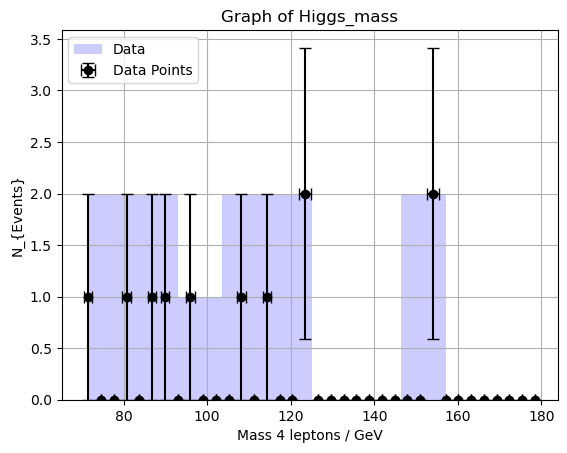

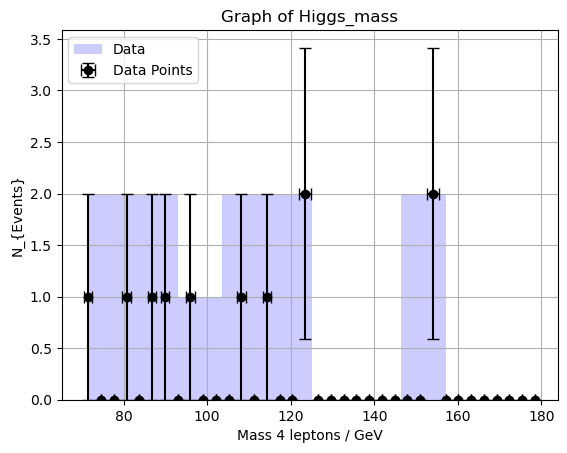

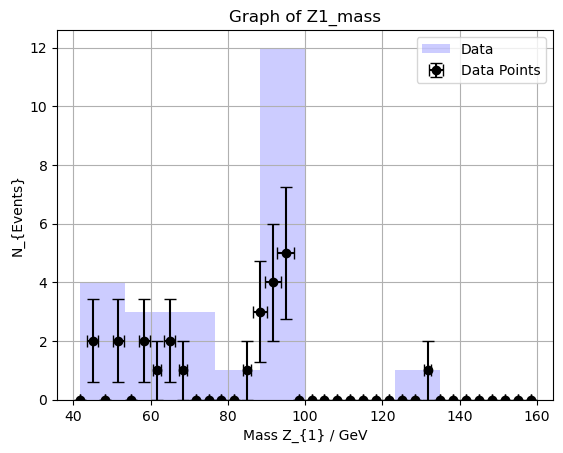

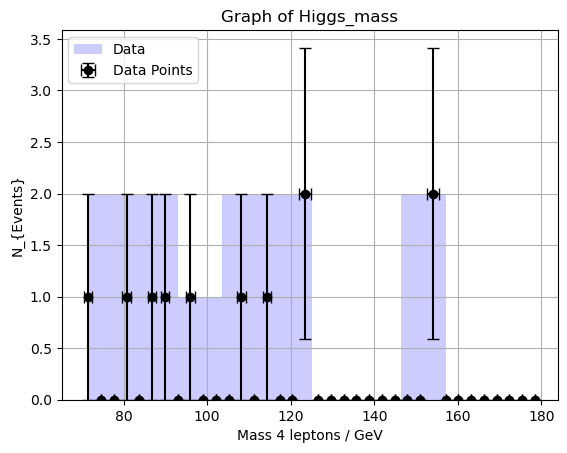

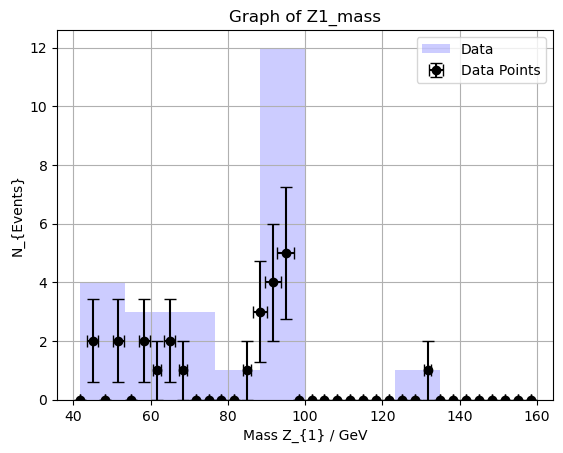

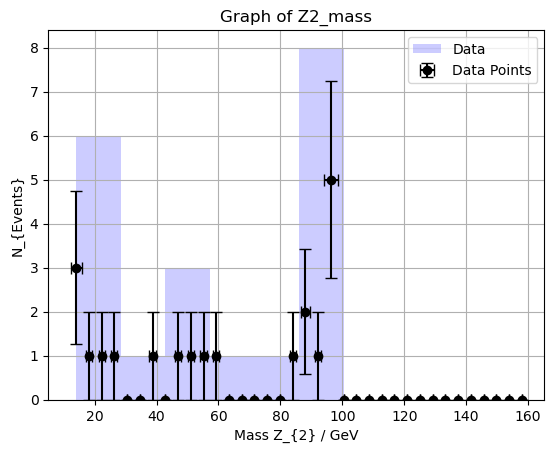

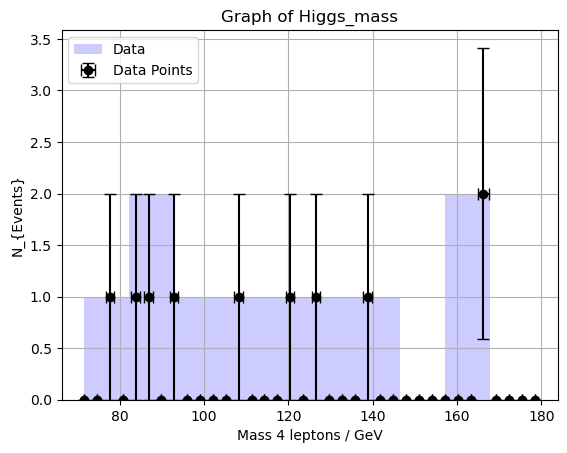

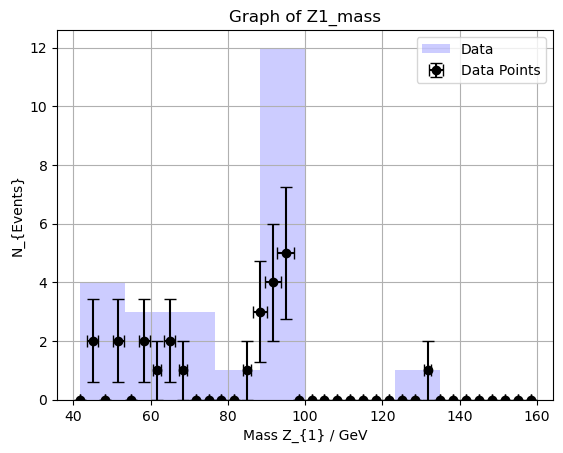

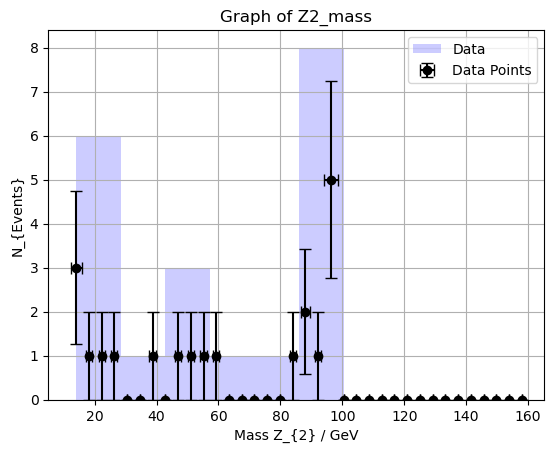

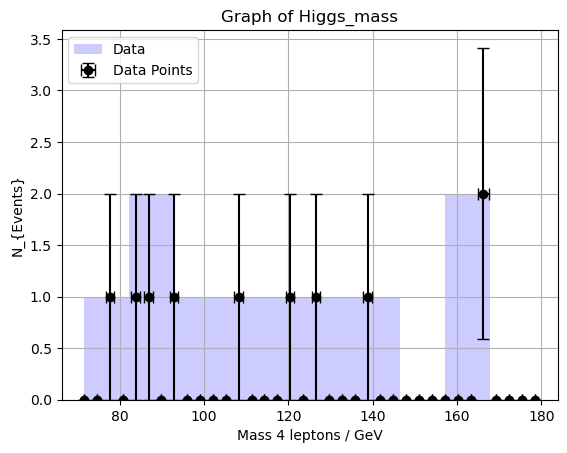

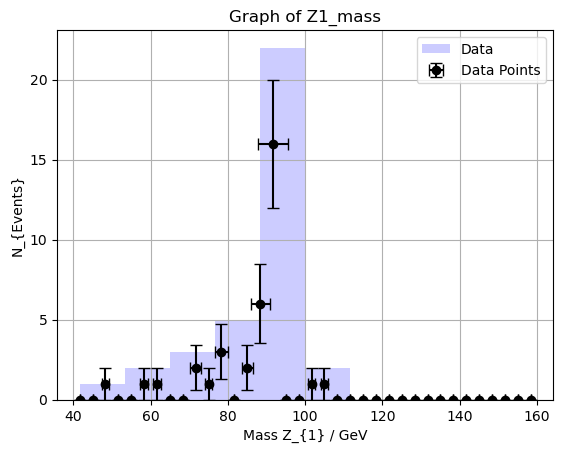

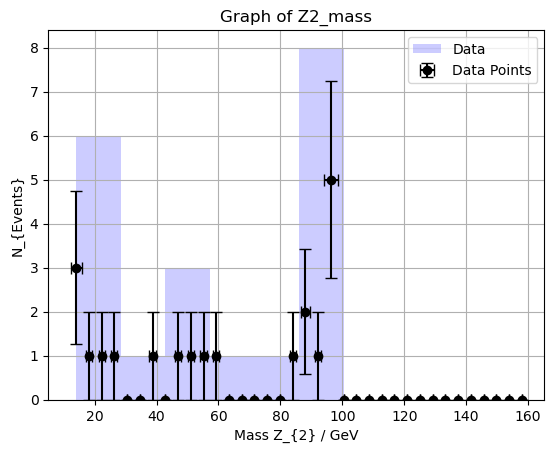

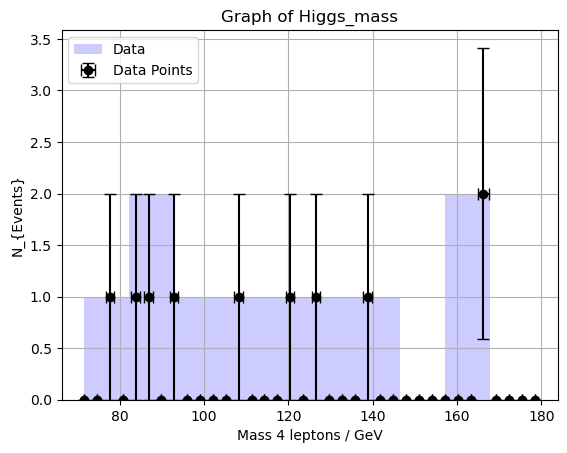

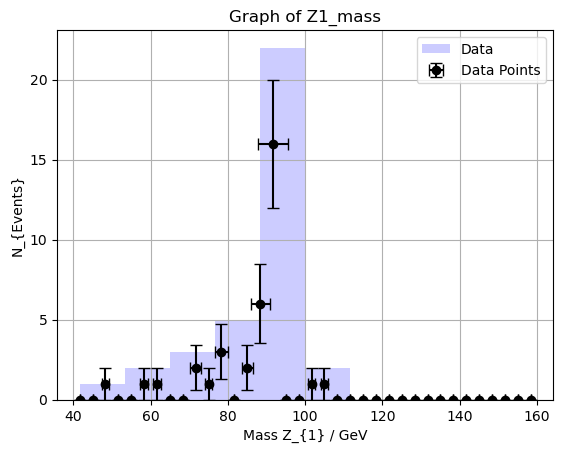

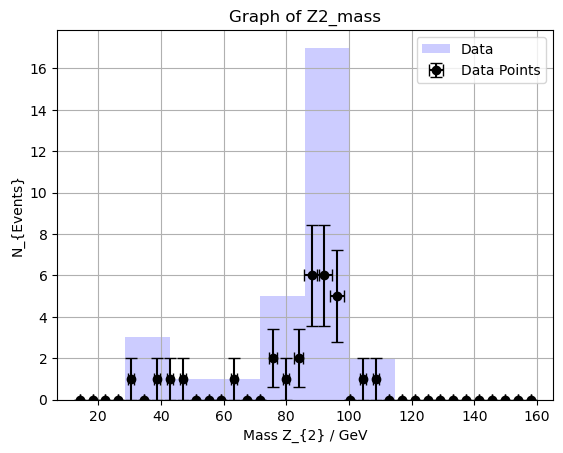

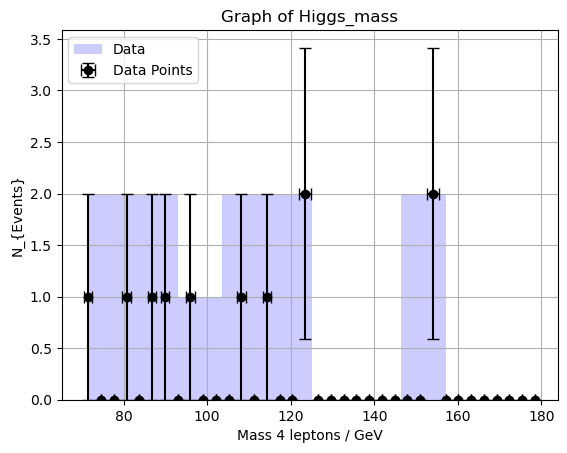

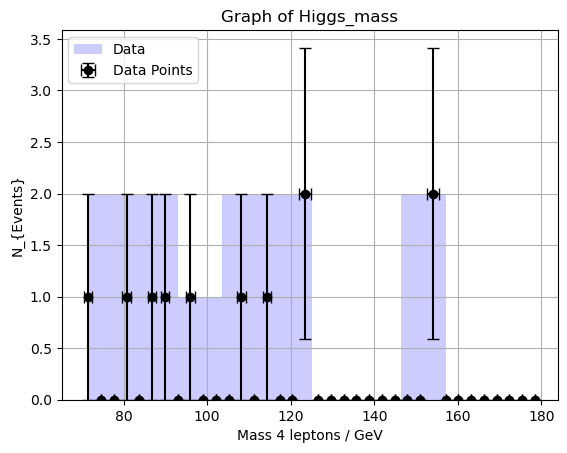

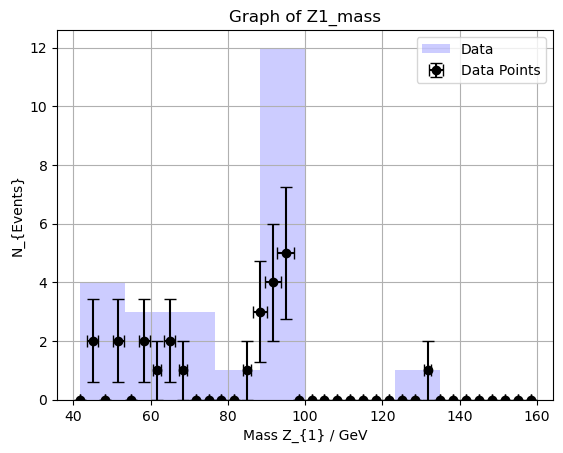

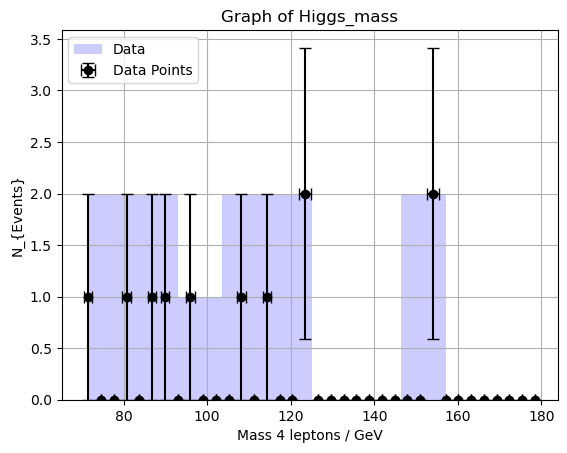

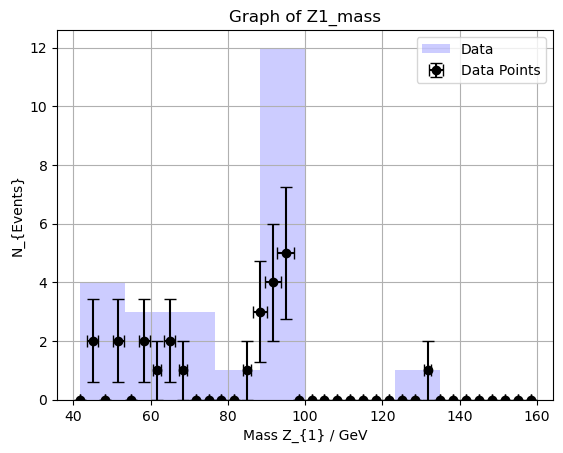

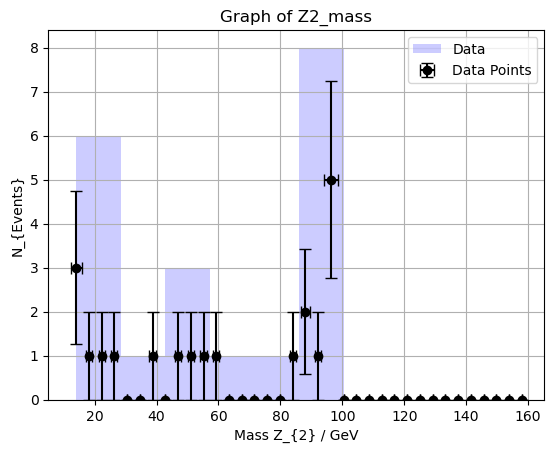

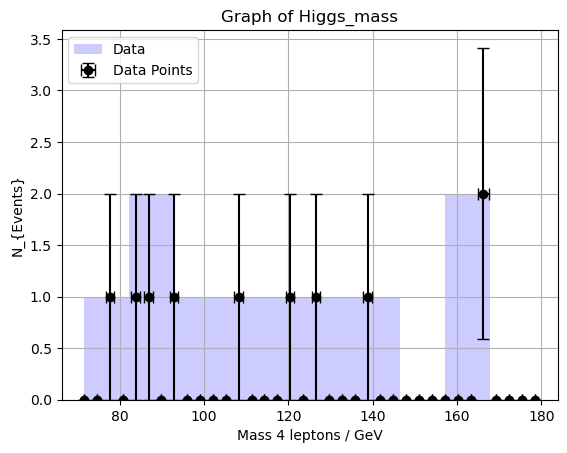

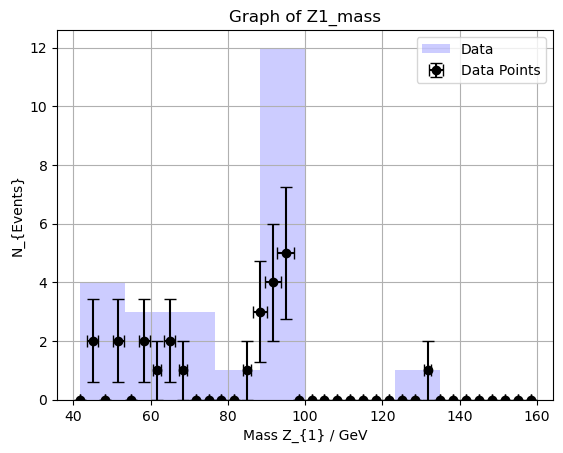

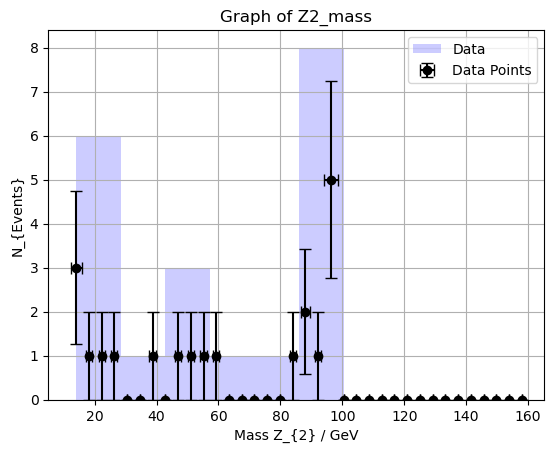

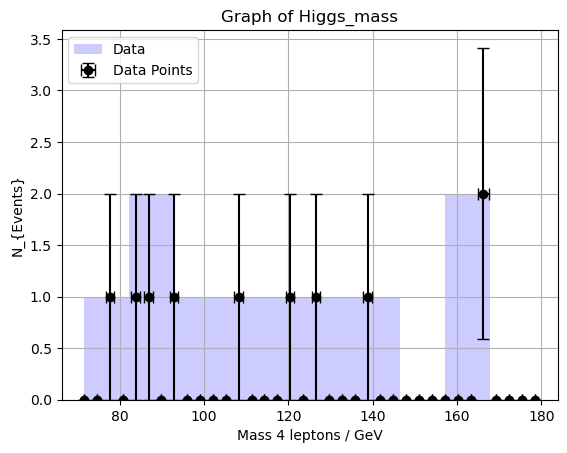

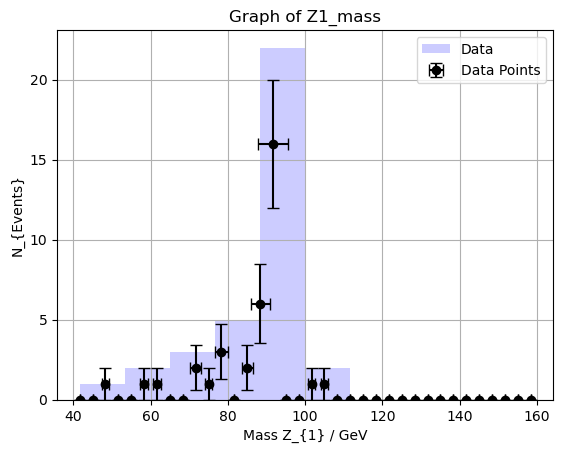

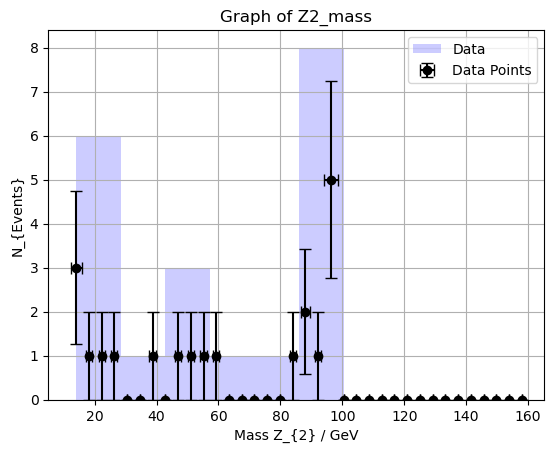

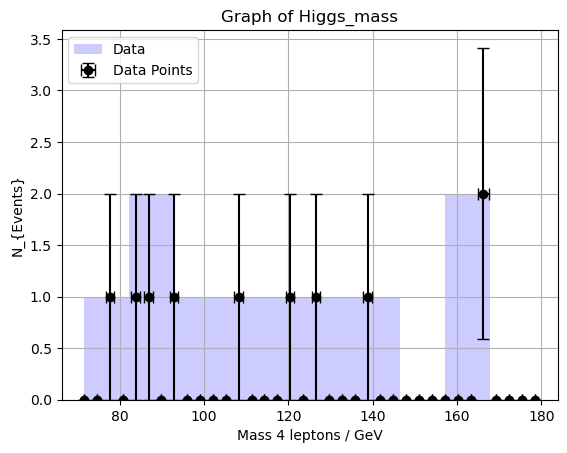

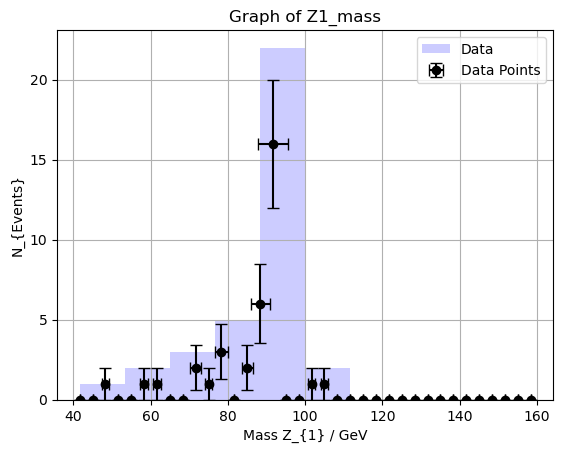

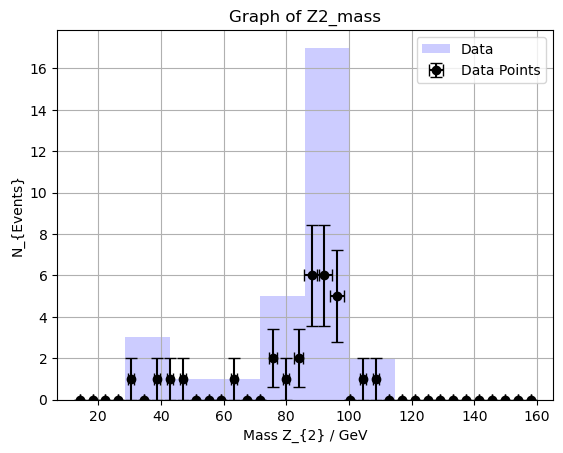

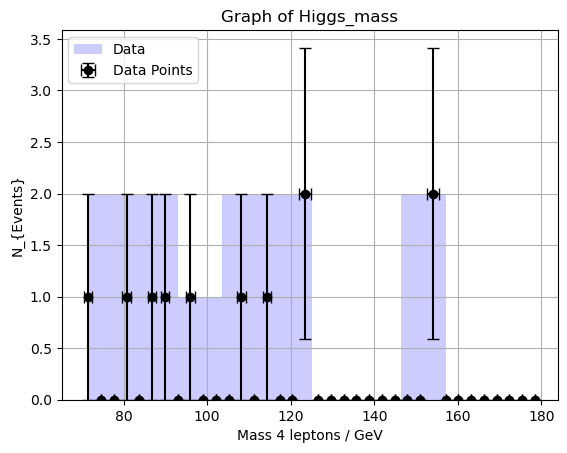

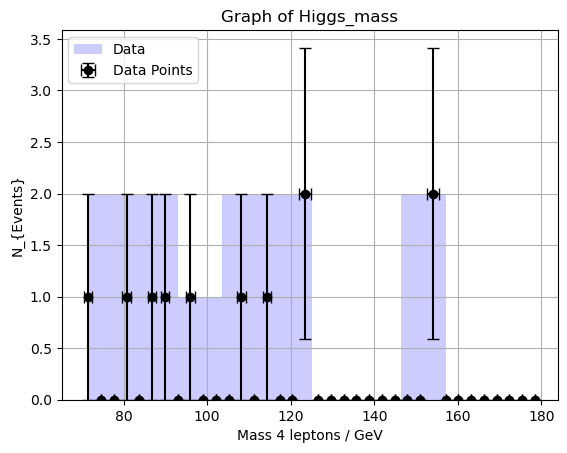

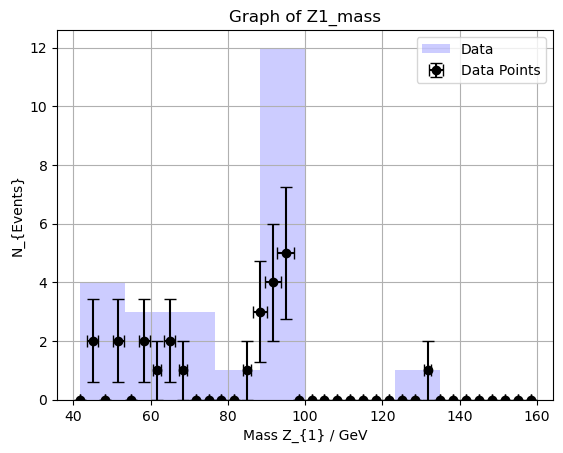

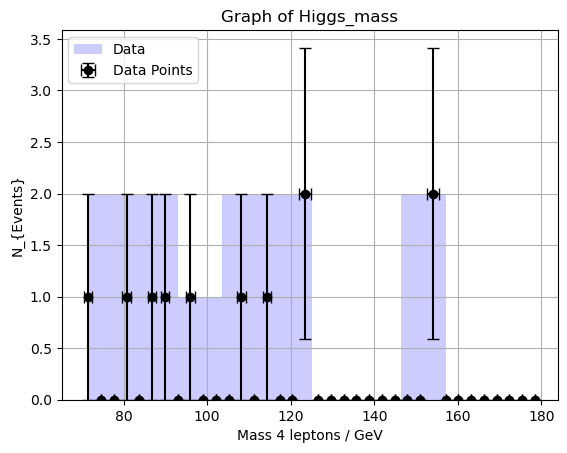

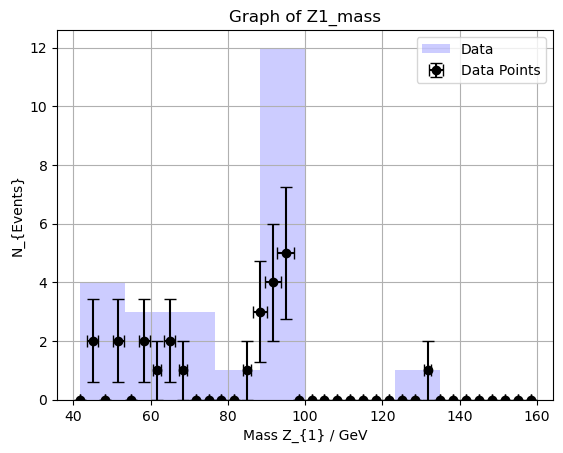

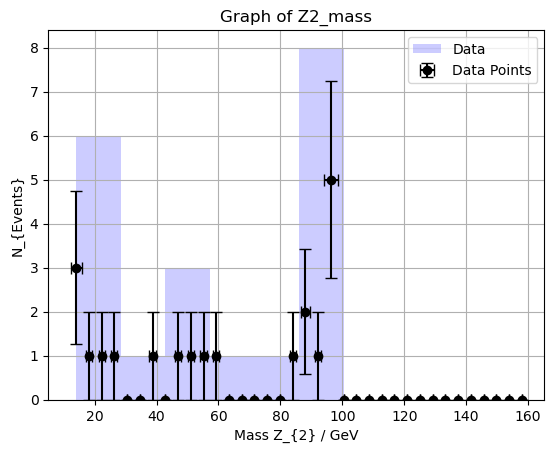

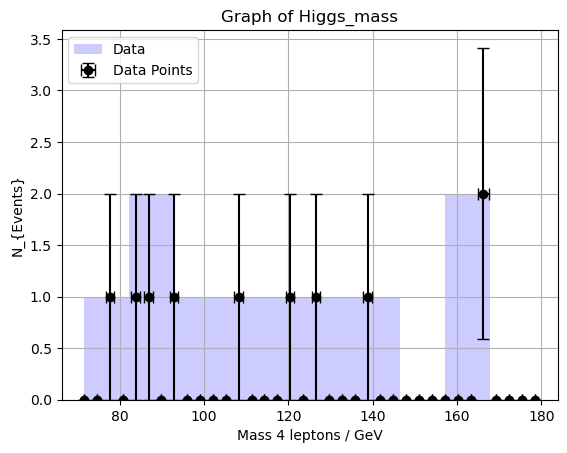

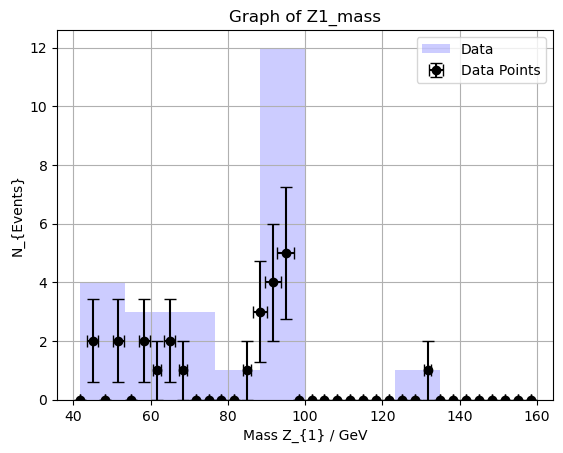

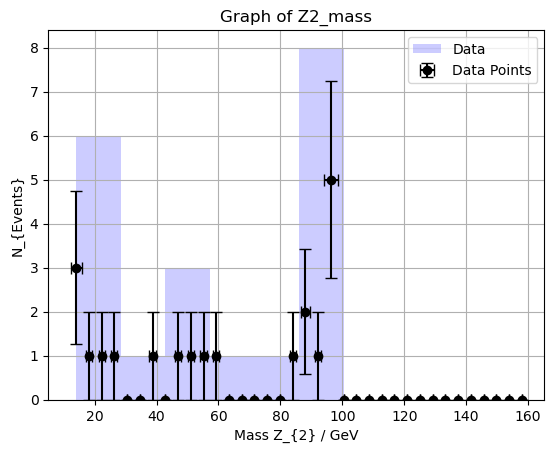

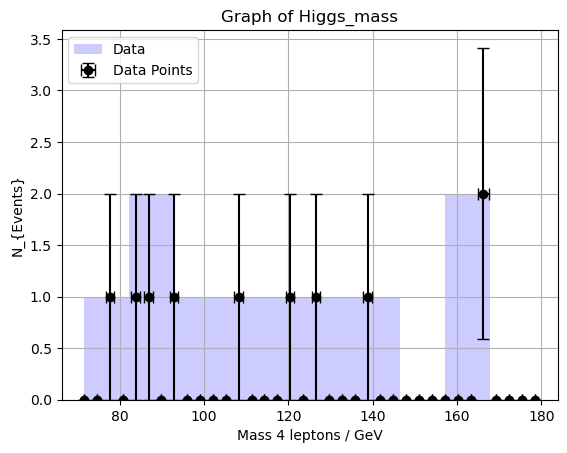

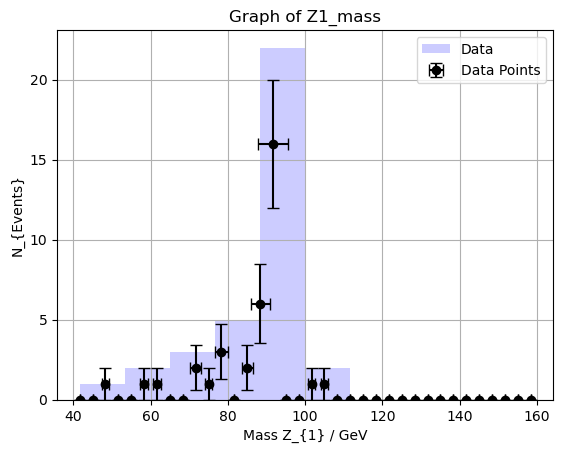

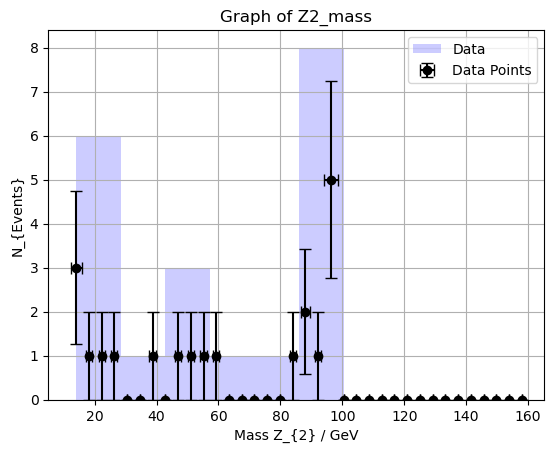

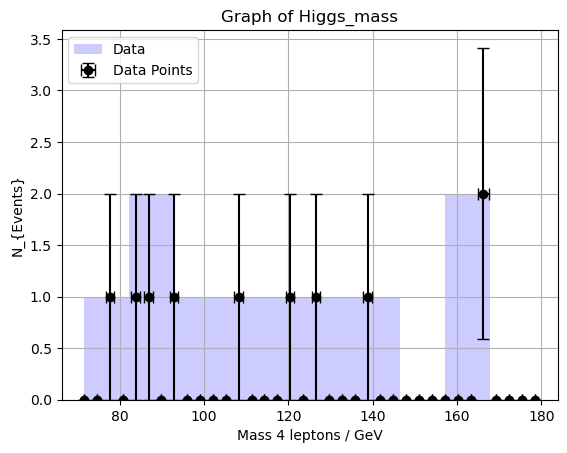

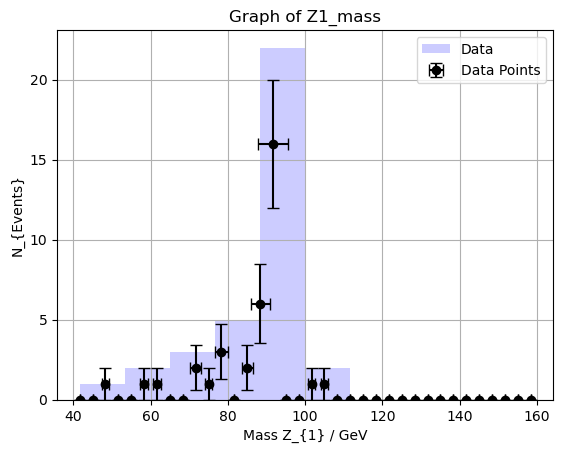

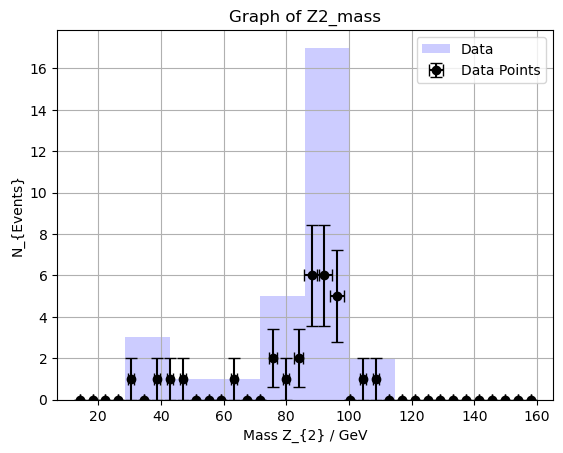

In [93]:
# Declare a human-readable label for each variable on the plot axis
variable_labels = {
    "Higgs_mass": "Mass 4 leptons / GeV",
    "Z1_mass": "Mass Z_{1} / GeV",
    "Z2_mass": "Mass Z_{2} / GeV",
}


# Main function of the plotting step
def main(variable):
    # Load histograms from the input file
    histograms = {}
    for final_state, samples in [["FourElectrons", "Run2012B_DoubleElectron_filtrado"], ["TwoMuonsTwoElectrons", "Run2012B_DoubleElectron_filtrado"]]:
        for variable in variable_labels.keys():
            file_name = "{}_{}_{}.txt".format(samples, final_state, variable)
            data = pd.read_csv(file_name, delim_whitespace=True, header=0, names=["BinCenter", "BinContent"])
            histograms[variable] = data

            # Plot histograms
            for variable, data in histograms.items():
                plt.figure()
                plt.hist(data["BinCenter"], bins=10, weights=data["BinContent"], label="Data",color="blue", linewidth=2, alpha=0.2)
                 
              # Plot data points with error bars
                plt.errorbar(data["BinCenter"], data["BinContent"], xerr=np.sqrt(data["BinContent"]), yerr=np.sqrt(data["BinContent"]), fmt='o', color='black', label='Data Points', capsize=4, capthick=1)
                
                plt.xlabel(variable_labels[variable])
                plt.ylabel("N_{Events}")
                plt.title(f"Graph of {variable}")
                plt.legend()
                plt.grid(True)
                plt.savefig("{}_{}_{}.png".format(samples, final_state, variable))
                plt.show()

# Loop over all variable names and make a plot for each
if __name__ == "__main__":
    for variable in variable_labels.keys():
        main(variable)
